### Preparation

In [90]:
import cyvcf2
import pybedtools as pb
import pandas as pd
import os
from itertools import product
import numpy as np
from matplotlib import pyplot as plt


In [91]:
raw_vc_sets = {
    "HG002": {
        "manta": {
            "illumina_150bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/illumina_60x/manta/results/variants/diploidSV.vcf.gz",
            "illumina_250bp": "" ## Exit code -11, PyFlow error ?
        },
        "delly": {
            "illumina_150bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/illumina_60x/delly/HG002.delly.bcf",
            "illumina_250bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/illumina_2x250bp/delly/HG002.delly.bcf"
        },
        "lumpy": {
            "illumina_150bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/illumina_60x/lumpy/HG002.lumpy.gt.vcf.gz",
            "illumina_250bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/illumina_2x250bp/lumpy/HG002.lumpy.gt.vcf.gz"
        }
    },
    "HG003": {
        "manta": {
            "illumina_150bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG003/structural_variants/illumina_60x/manta/results/variants/diploidSV.vcf.gz",
            "illumina_250bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG003/structural_variants/illumina_2x250bp/manta/results/variants/diploidSV.vcf.gz" 
        },
        "delly": {
            "illumina_150bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG003/structural_variants/illumina_60x/delly/HG003.delly.bcf", 
            "illumina_250bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG003/structural_variants/illumina_2x250bp/delly/HG003.delly.bcf"
        },
        "lumpy": {
            "illumina_150bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG003/structural_variants/illumina_60x/lumpy/HG003.lumpy.gt.vcf.gz", 
            "illumina_250bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG003/structural_variants/illumina_2x250bp/lumpy/HG003.lumpy.gt.vcf.gz"
        }
    },
    "HG004": {
        "manta": {
            "illumina_150bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG004/structural_variants/illumina_60x/manta/results/variants/diploidSV.vcf.gz",
            "illumina_250bp": "" ## Exit code -11, no output
        },
        "delly": {
            "illumina_150bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG004/structural_variants/illumina_60x/delly/HG004.delly.bcf", 
            "illumina_250bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG004/structural_variants/illumina_2x250bp/delly/HG004.delly.bcf"
        },
        "lumpy": {
            "illumina_150bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG004/structural_variants/illumina_60x/lumpy/HG004.lumpy.gt.vcf.gz", 
            "illumina_250bp": "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG004/structural_variants/illumina_2x250bp/lumpy/HG004.lumpy.gt.vcf.gz"
        }
    }
}

In [92]:
benchmark_region_fp = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/benchmark_data/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.bed"
bench_region = pb.BedTool(benchmark_region_fp)

In [93]:
def extract_variant_by_region(vcf, regions, type=""):
    '''
    Excludes:
    Variants with size < 50bp
    BND
    Allosomal SVs
    SVs not satisfying bench type   
    '''
    filtered_variants = {}
    for region in regions:
        chrom = region.chrom
        start = region.start + 1
        end = region.stop + 1
        
        chroms = list(map(str, range(1, 23)))
        
        if chrom not in chroms: ## Only include autosomal SVs 
            continue
        
        for variant in vcf(f"{chrom}:{start}-{end}"):
            if variant.INFO["SVTYPE"] == "BND":
                continue
            varsize = abs(variant.INFO.get("SVLEN") or variant.INFO.get("END") - variant.POS)
            if varsize < 50:
                continue
            
            if variant.INFO["SVTYPE"] != "DEL":
                if start <= variant.POS <= end:
                    filtered_variants[variant.ID] = variant
                continue
            
            if type == "both":
                if variant.POS >= start and variant.end <= end:
                    filtered_variants[variant.ID] = variant
            elif type == "either":
                if start < variant.POS < end or start < variant.end < end:
                    filtered_variants[variant.ID] = variant
                elif variant.POS < start and variant.end > end:
                    filtered_variants[variant.ID] = variant
                    
    return list(sorted(filtered_variants.values(), key=lambda x: (x.CHROM, x.POS)))

In [94]:
root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/{}/{}/{}/60x/"

samples = ["HG002", "HG003", "HG004"]
bench = ["both", "either"]
platforms = ["illumina_150bp"] #, "illumina_250bp"]
caller = ["manta", "delly", "lumpy"]
combinations = list(product(samples, bench, platforms, caller))

for combo in combinations:
    cur_root = root.format(*combo)
    
    candidate_fp = f"{cur_root}/candidates.vcf.gz"
    filtered_fp = f"{cur_root}/filtered.vcf.gz"


### SV distribution of 9 callsets

Figure S1. Distribution of structural variations (SVs) in 16 callsets derived from selected GIAB samples. SVs included in "both" benchmarks are shown on the left while SVs included in "either" benchmarks are shown on the right. We profiled SVs called from PE150 and PE250 alignment files using Manta, DELLY and Lumpy. SVs without PASS filter tag or <50bp are excluded; only DEL and INS are excluded. 

In [95]:
from collections import Counter

count_df = {}

for combo in combinations:
    sample, bench, platform, caller = combo
    alias = f"{sample}_{bench}_{platform.split('_')[-1]}_{caller[0].upper()}"

    raw_vcfp = raw_vc_sets[sample][caller][platform]
    if not os.path.exists(raw_vcfp):
        continue
    raw_vcf = cyvcf2.VCF(raw_vc_sets[sample][caller][platform], gts012=True)
    variants = extract_variant_by_region(raw_vcf, bench_region, type=bench)
    variants = list(filter(lambda v: v.INFO["SVTYPE"] in ["DEL", "INS"] and v.FILTER is None and v.gt_types[0] in [1, 2], variants)) ## PASS variants, and inclyde HET and HOM variants
    ##############################################################################
    
    variant_categories = [(v.INFO.get("SVTYPE"), v.gt_types[0]) for v in variants]
    count = Counter(variant_categories)
    count_df[alias] = count
    
    raw_vcf.close()

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame.from_dict(count_df, orient="index").fillna(0).astype(int)
df.columns = ["HOM DEL", "HET DEL", "HOM INS", "HET INS"] # ['{}_{}'.format(l0, l1) for l0, l1 in df.columns]
df = df.loc[:, ["HET DEL", "HOM DEL", "HET INS", "HOM INS"]]
both_df, either_df = df.loc[df.index.str.contains("both"), :], df.loc[df.index.str.contains("either"), :]

both_df = both_df.loc[reversed(both_df.index), :]
either_df = either_df.loc[reversed(either_df.index), :]

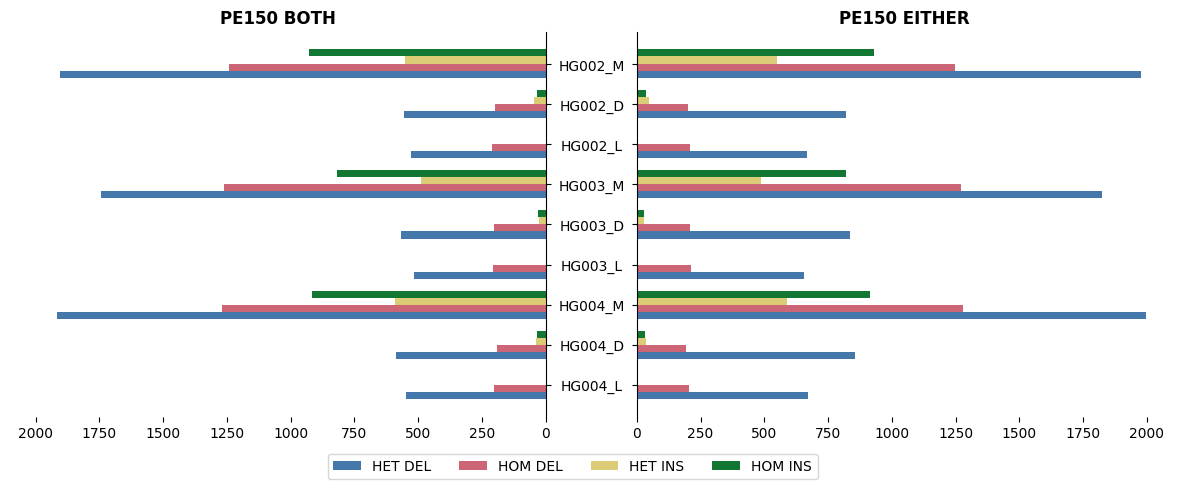

In [ ]:

import numpy as np
from matplotlib import pyplot as plt

both_pe150_df = both_df.loc[both_df.index.str.contains("150bp"), :]
either_pe150_df = either_df.loc[either_df.index.str.contains("150bp"), :]
# both_pe250_df = both_df.loc[both_df.index.str.contains("250bp"), :]
# either_pe250_df = either_df.loc[either_df.index.str.contains("250bp"), :]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=False, sharey="row")
fig.subplots_adjust(hspace=0.5, wspace=0.17)

def make_subplot(df, ax=None, loc = "right", title=None):
    ind = np.arange(0, df.shape[0] * 2, 2)
    index_labels = df.index.str.replace("150bp_", "")
    # index_labels = index_labels.str.replace("250bp_", "")
    index_labels = index_labels.str.replace("both_", "")
    index_labels = index_labels.str.replace("either_", "")
    width = 0.35
    
    color_het_del = '#4477AA'  
    color_hom_del = '#CC6677'  
    color_het_ins = '#DDCC77'  
    color_hom_ins = '#117733'
    
    opacity = 1.0
    
    if loc == "right": # right
        ax.barh(ind - 1.5 * width, df["HET DEL"], width, label="HET DEL", color=color_het_del, alpha=opacity)
        ax.barh(ind - 0.5 * width, df["HOM DEL"], width, label="HOM DEL", color=color_hom_del, alpha=opacity)
        ax.barh(ind + 0.5 * width, df["HET INS"], width, label="HET INS", color=color_het_ins, alpha=opacity)
        ax.barh(ind + 1.5 * width, df["HOM INS"], width, label="HOM INS", color=color_hom_ins, alpha=opacity)
        ax.set_yticks(ind)
        ax.set_yticklabels([""] * len(index_labels))
        # ax.set_yticklabels(index_labels, rotation=0, fontsize=10, ha="center", position=(115,10))
        ax.set_xlim(0, 2100)
        ax.spines['right'].set_visible(False)

    else: # left
        ax.barh(ind - 1.5 * width, df["HET DEL"], width, label="HET DEL", color=color_het_del, alpha=opacity)
        ax.barh(ind - 0.5 * width, df["HOM DEL"], width, label="HOM DEL", color=color_hom_del, alpha=opacity)
        ax.barh(ind + 0.5 * width, df["HET INS"], width, label="HET INS", color=color_het_ins, alpha=opacity)
        ax.barh(ind + 1.5 * width, df["HOM INS"], width, label="HOM INS", color=color_hom_ins, alpha=opacity)
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xlim(0, 2100)
        ax.invert_xaxis()
        ax.yaxis.tick_right()
        ax.spines['left'].set_visible(False)
              
    ax.set_title(title, fontweight="bold")    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    return ax, index_labels

_, labels1 = make_subplot(both_pe150_df, axes[0], loc="left", title="PE150 BOTH")
make_subplot(either_pe150_df, axes[1], loc="right", title="PE150 EITHER")
# _, labels2 = make_subplot(both_pe250_df, axes[1, 0], loc="left", title="PE250 BOTH")
# make_subplot(either_pe250_df, axes[1, 1], loc="right", title="PE250 EITHER")  

for i, label in enumerate(reversed(labels1)):
    fig.text(0.513, 0.81 - i * 0.08, label, ha='center', va='center', fontsize=10)

# for i, label in enumerate(reversed(labels2)):
#     fig.text(0.513, 0.387 - i * 0.0419, label, ha='center', va='center', fontsize=10)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4)

plt.show()


### SV distribution of 3 selected GIAB samples

In [ ]:
HG002_raw_bench = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/benchmark_data/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz"

raw_vcf = cyvcf2.VCF(HG002_raw_bench, gts012=True)

het_repr = ["0/1", "1/0", "0|1", "1|0"]

count_df = {}
for bench in ["both", "either"]:
    variants = extract_variant_by_region(raw_vcf, bench_region, type=bench)
    count_df[bench] = variants
    HG002_variants = list(filter(lambda v: v.FILTER is None and v.gt_types[0] in [1, 2], variants))
    variant_categories = [(v.INFO.get("SVTYPE"), "HET" if v.gt_types[0] == 1 else "HOM") for v in HG002_variants] ## True -> HET, False -> HOM
    HG002_count = Counter(variant_categories)
    count_df[f"HG002-{bench}"] = HG002_count
    
    HG003_variants = list(filter(lambda v: "." not in v.INFO["HG003_GT"] and v.FILTER != "lt50bp", variants)) ## Exclude missing genotypes
    variant_categories = [(v.INFO.get("SVTYPE"), "HET" if v.INFO["HG003_GT"] in het_repr else "HOM") for v in HG003_variants] ## True -> HET, False -> HOM
    HG003_count = Counter(variant_categories)
    count_df[f"HG003-{bench}"] = HG003_count

    HG004_variants = list(filter(lambda v: "." not in v.INFO["HG004_GT"] and v.FILTER != "lt50bp", variants))
    variant_categories = [(v.INFO.get("SVTYPE"), "HET" if v.INFO["HG004_GT"] in het_repr else "HOM") for v in HG004_variants]
    HG004_count = Counter(variant_categories)
    count_df[f"HG004-{bench}"] = HG004_count
    
    del count_df[bench]
raw_vcf.close()



In [ ]:
df = pd.DataFrame.from_dict(count_df, orient="index").fillna(0).astype(int)
df.columns = ["HOM DEL", "HOM INS", "HET INS", "HET DEL"]
df = df.loc[:, ["HET DEL", "HOM DEL", "HET INS", "HOM INS"]]
both_df, either_df = df.loc[df.index.str.contains("both"), :], df.loc[df.index.str.contains("either"), :]

both_df = both_df.loc[reversed(both_df.index), :]
either_df = either_df.loc[reversed(either_df.index), :]


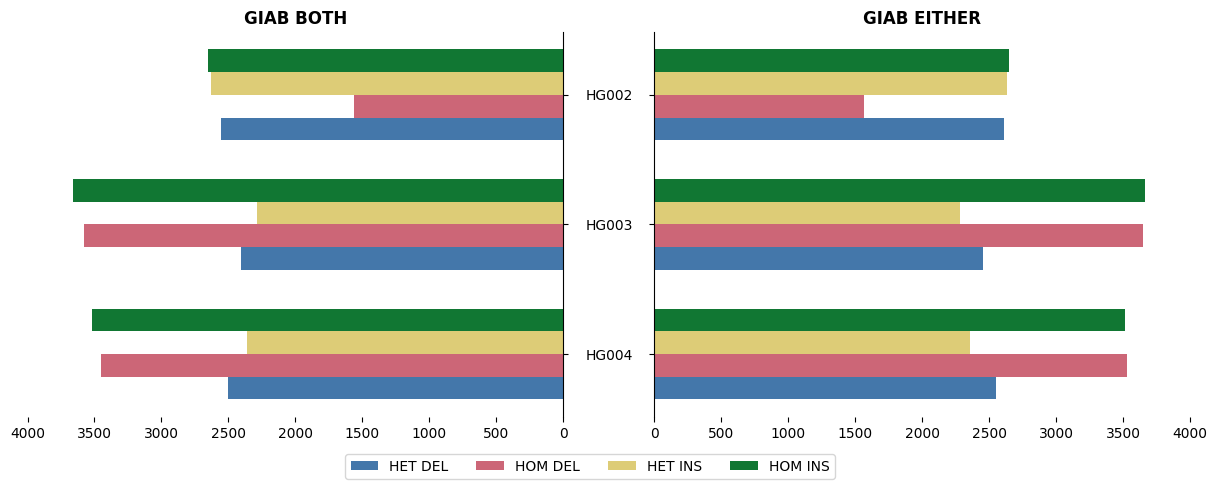

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=False, sharey="row")
fig.subplots_adjust(wspace=0.17)

def make_subplot(df, ax=None, loc = "right", title=None):
    ind = np.arange(0, df.shape[0] * 2, 2)
    index_labels = df.index.str.replace("-both", "")
    index_labels = index_labels.str.replace("-either", "")
    width = 0.35
    
    color_het_del = '#4477AA'  
    color_hom_del = '#CC6677'  
    color_het_ins = '#DDCC77'  
    color_hom_ins = '#117733'
    
    opacity = 1.0
    
    if loc == "right": # right
        ax.barh(ind - 1.5 * width, df["HET DEL"], width, label="HET DEL", color=color_het_del, alpha=opacity)
        ax.barh(ind - 0.5 * width, df["HOM DEL"], width, label="HOM DEL", color=color_hom_del, alpha=opacity)
        ax.barh(ind + 0.5 * width, df["HET INS"], width, label="HET INS", color=color_het_ins, alpha=opacity)
        ax.barh(ind + 1.5 * width, df["HOM INS"], width, label="HOM INS", color=color_hom_ins, alpha=opacity)
        ax.set_yticks(ind)
        ax.set_yticklabels([""] * len(index_labels))
        # ax.set_yticklabels(index_labels, rotation=0, fontsize=10, ha="center", position=(115,10))
        ax.set_xlim(0, 4000)
        ax.spines['right'].set_visible(False)

    else: # left
        ax.barh(ind - 1.5 * width, df["HET DEL"], width, label="HET DEL", color=color_het_del, alpha=opacity)
        ax.barh(ind - 0.5 * width, df["HOM DEL"], width, label="HOM DEL", color=color_hom_del, alpha=opacity)
        ax.barh(ind + 0.5 * width, df["HET INS"], width, label="HET INS", color=color_het_ins, alpha=opacity)
        ax.barh(ind + 1.5 * width, df["HOM INS"], width, label="HOM INS", color=color_hom_ins, alpha=opacity)
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xlim(0, 4000)
        ax.invert_xaxis()
        ax.yaxis.tick_right()
        ax.spines['left'].set_visible(False)
              
    ax.set_title(title, fontweight="bold")    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    return ax, index_labels


_, labels1 = make_subplot(both_df, axes[0], loc="left", title="GIAB BOTH")
make_subplot(either_df, axes[1], loc="right", title="GIAB EITHER")


for i, label in enumerate(reversed(labels1)):
    fig.text(0.513, 0.753 - i * 0.26, label, ha='center', va='center', fontsize=10)


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4)

plt.show()

### Length distribution of benchmark heterozygous deletions


In [ ]:
def get_sizes(both_vcf_fp, either_vcf_fp):
    both_vcf, either_vcf = cyvcf2.VCF(both_vcf_fp, gts012=True), cyvcf2.VCF(either_vcf_fp, gts012=True) ## only heterozygous deletions here
    
    both_sizes, either_sizes = [], []
    for variant in both_vcf():
        varsize = abs(variant.INFO.get("SVLEN") or variant.INFO.get("END") - variant.POS)
        both_sizes.append(varsize)
    for variant in either_vcf():
        varsize = abs(variant.INFO.get("SVLEN") or variant.INFO.get("END") - variant.POS)
        either_sizes.append(varsize)
    both_vcf.close()
    either_vcf.close()
    
    return both_sizes, either_sizes

def get_category_counts(sizes):
    categories = {"50to500": 0, "500to5000": 0, "gt5000": 0}
    for varsize in sizes:
        if 50 <= varsize < 500:
            categories["50to500"] += 1
        elif 500 <= varsize < 5000:
            categories["500to5000"] += 1
        elif varsize >= 5000:
            categories["gt5000"] += 1
            
    return categories

def plot_stacked_bar(size_cat, ax):
    
    width = 0.1
    bar_colors = ['#3274A1', '#E1812C', '#3A923A']  # blue, orange, green
    
    p1 = ax.bar(0, size_cat["50to500"], width, label='50-500', color=bar_colors[0])
    p2 = ax.bar(0, size_cat["500to5000"], width, bottom=size_cat["50to500"], 
               label='500-5000', color=bar_colors[1])
    p3 = ax.bar(0, size_cat["gt5000"], width, 
               bottom=size_cat["50to500"] + size_cat["500to5000"], 
               label='>5000', color=bar_colors[2])
    
    # Add total count on top of bar
    total = sum(size_cat.values())
    ax.text(0, total + 0.5, str(total), ha='center', fontsize=10)
    
    ax.get_xaxis().set_visible(False)
    for loc in ['top', 'right', 'bottom']:
        ax.spines[loc].set_visible(False)

    return ax

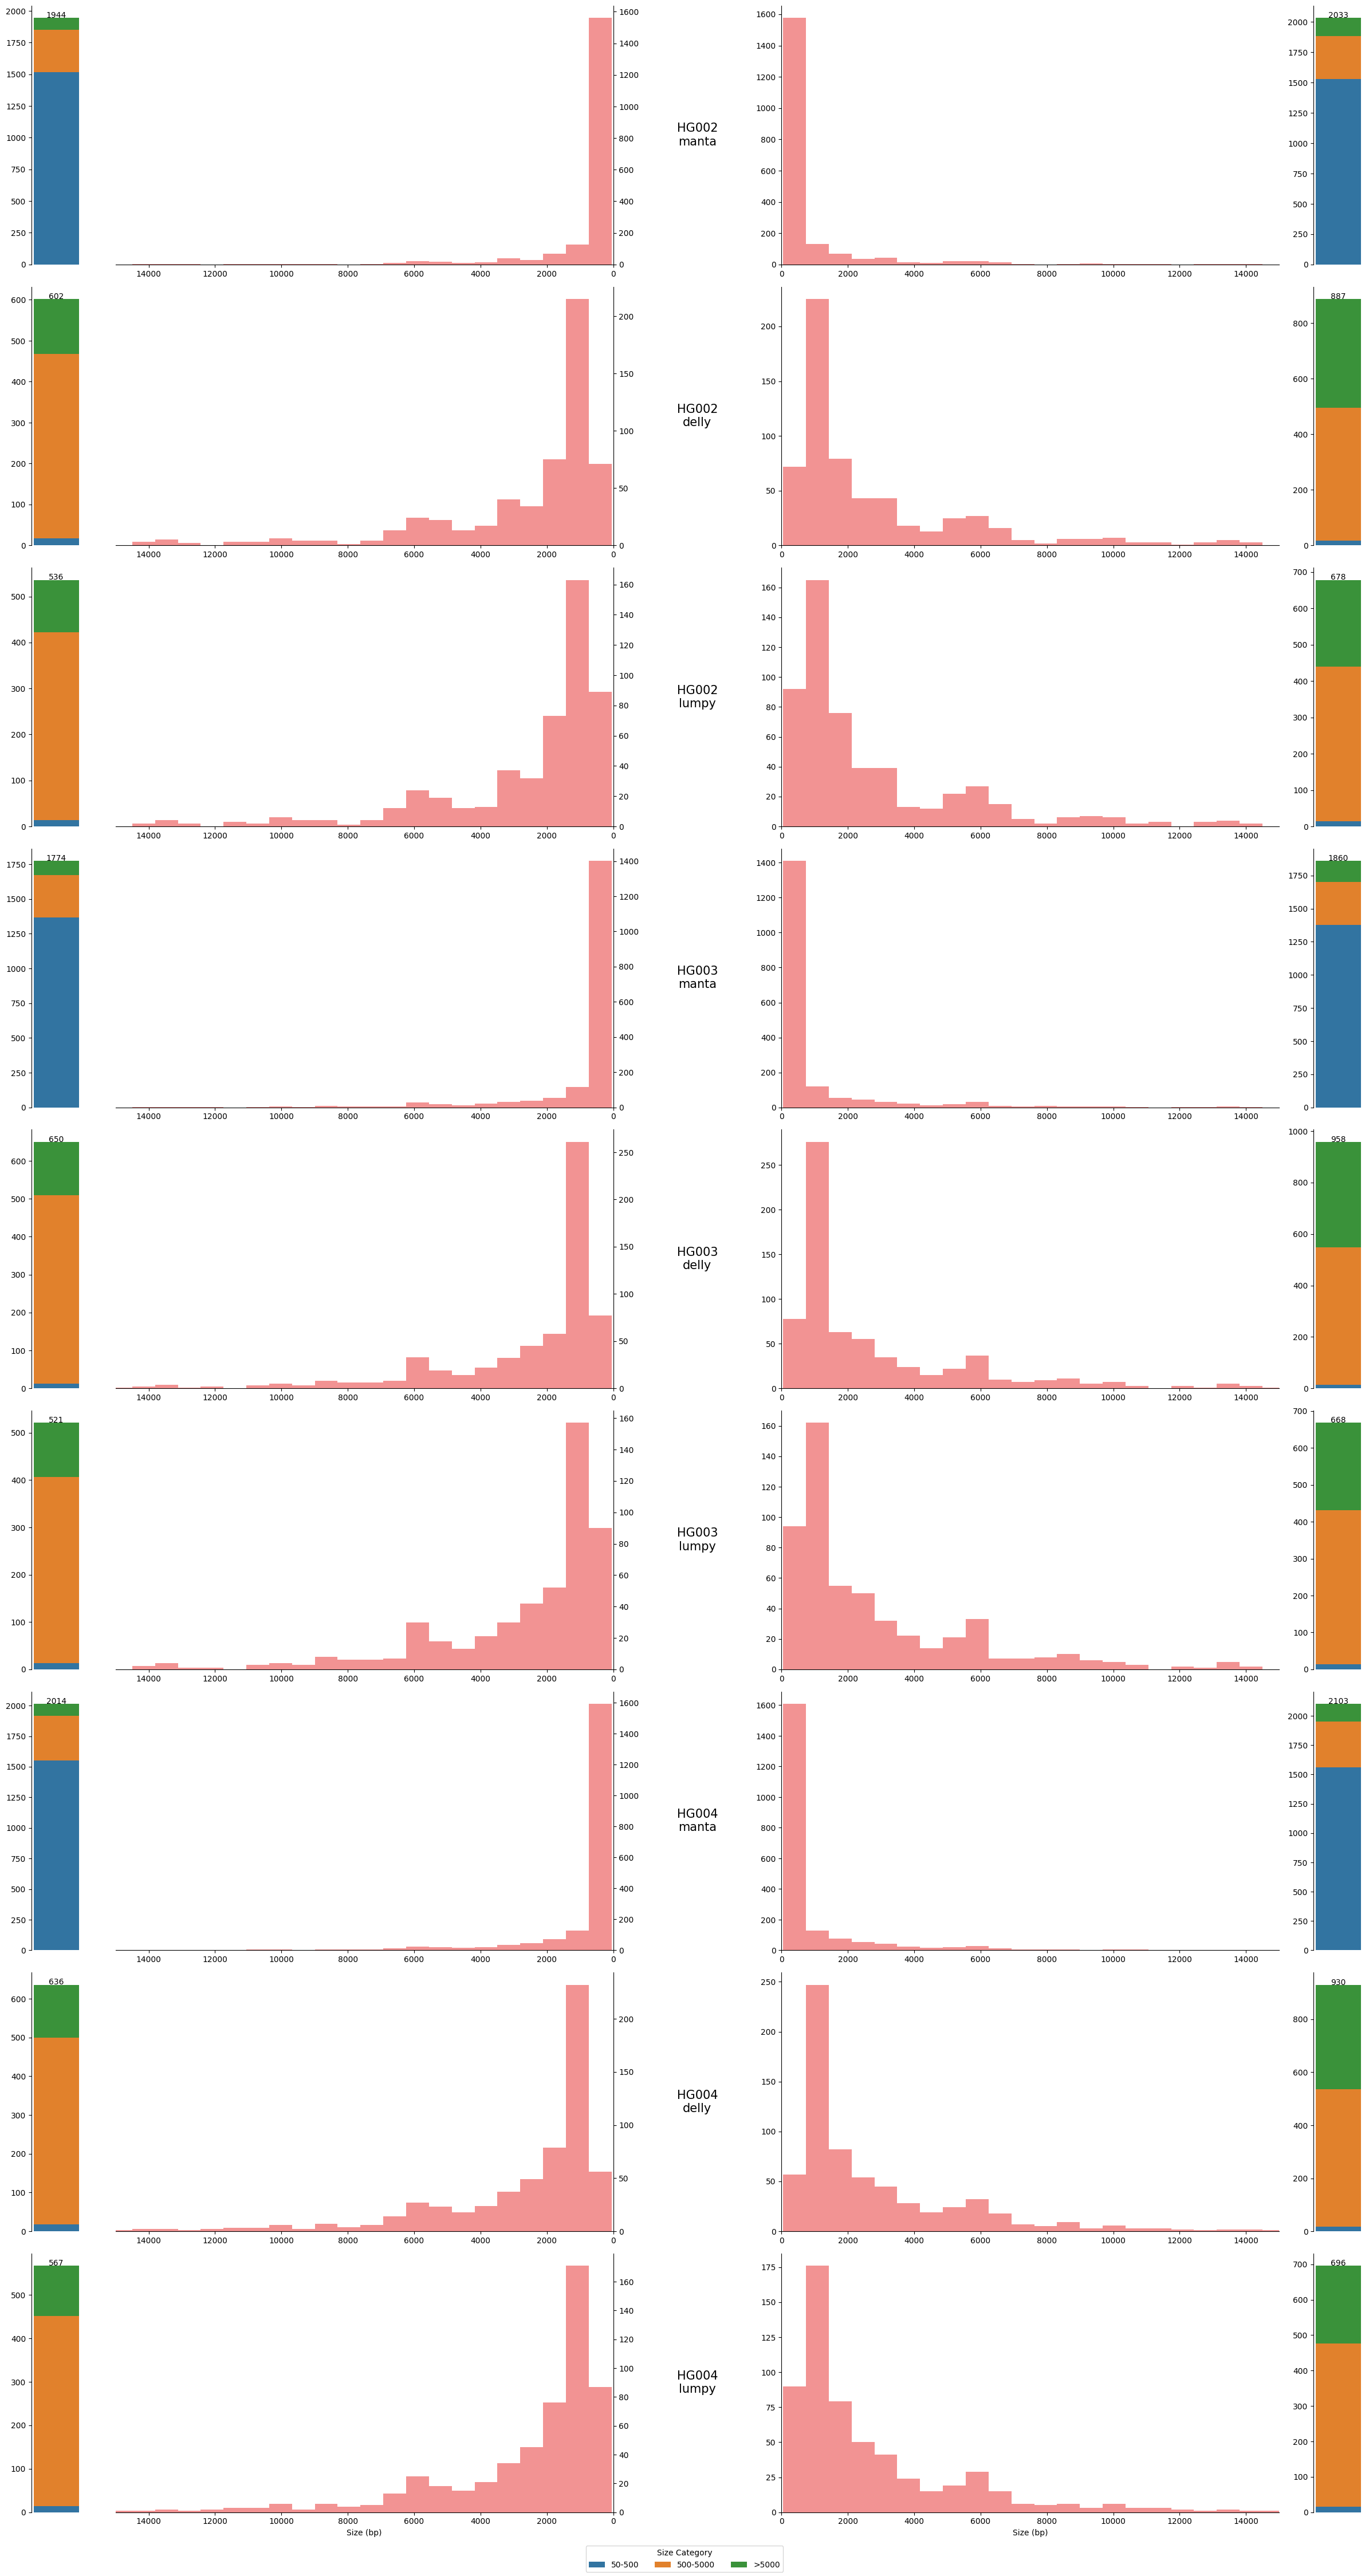

In [ ]:
root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/{}/{}/{}/60x/"

samples = ["HG002", "HG003", "HG004"]
bench = ["both", "either"]
platforms = ["illumina_150bp"]
caller = ["manta", "delly", "lumpy"]
combinations = list(product(samples, platforms, caller))

fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(30, 50), width_ratios=[0.1, 1, 0.2, 1, 0.1])
fig.subplots_adjust(hspace=0.2, wspace=0.0)

idx = 0
for combo in combinations:
    sample, platform, caller_name = combo
    both_root = root.format(sample, "both", platform, caller_name)
    either_root = root.format(sample, "either", platform, caller_name)
    
    both_candidates = f"{both_root}/candidates.vcf.gz"
    either_candidates = f"{either_root}/candidates.vcf.gz"
    
    if os.path.exists(both_candidates) and os.path.exists(either_candidates):
        both_sizes, either_sizes = get_sizes(both_candidates, either_candidates)
        both_cat, either_cat = get_category_counts(both_sizes), get_category_counts(either_sizes)
        
        bins = np.linspace(50, 20000, 30)
        axes[idx, 1].hist(both_sizes, bins=bins, alpha=0.85, label="Both", color='#F08080')
        axes[idx, 1].set_xlim(0, 15000)
        axes[idx, 1].invert_xaxis()
        axes[idx, 1].yaxis.tick_right()
        axes[idx, 1].spines["top"].set_visible(False)
        axes[idx, 1].spines["left"].set_visible(False)
        
        axes[idx, 3].hist(either_sizes, bins=bins, alpha=0.85, label="Either", color='#F08080')
        axes[idx, 3].set_xlim(0, 15000)
        axes[idx, 3].spines["top"].set_visible(False)
        axes[idx, 3].spines["right"].set_visible(False)
        
        axes[idx, 2].set_axis_off()
        axes[idx, 2].text(0.5, 0.5, f"{sample}\n{caller_name}", ha="center", va="center", fontsize=15)

        if idx == 8:
            axes[idx, 1].set_xlabel("Size (bp)")
            axes[idx, 3].set_xlabel("Size (bp)")
        
        plot_stacked_bar(both_cat, axes[idx, 0])
        plot_stacked_bar(either_cat, axes[idx, 4])

        idx += 1

handles, labels = axes[0,0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower center', title='Size Category', ncols=3)
fig.tight_layout(rect=[0.1, 0.01, 0.9, 0.9])
plt.show()



### Length distribution of GIAB deletions

In [ ]:
def get_category_counts(sizes):
    categories = {"50to500": 0, "500to5000": 0, "gt5000": 0}
    for varsize in sizes:
        if 50 <= varsize < 500:
            categories["50to500"] += 1
        elif 500 <= varsize < 5000:
            categories["500to5000"] += 1
        elif varsize >= 5000:
            categories["gt5000"] += 1
            
    return categories

def plot_stacked_bar(size_cat, ax):
    
    width = 0.1
    bar_colors = ['#3274A1', '#E1812C', '#3A923A']  # blue, orange, green
    
    p1 = ax.bar(0, size_cat["50to500"], width, label='50-500', color=bar_colors[0])
    p2 = ax.bar(0, size_cat["500to5000"], width, bottom=size_cat["50to500"], 
               label='500-5000', color=bar_colors[1])
    p3 = ax.bar(0, size_cat["gt5000"], width, 
               bottom=size_cat["50to500"] + size_cat["500to5000"], 
               label='>5000', color=bar_colors[2])
    
    # Add total count on top of bar
    total = sum(size_cat.values())
    ax.text(0, total + 0.5, str(total), ha='center', fontsize=10)
    
    ax.get_xaxis().set_visible(False)
    for loc in ['top', 'right', 'bottom']:
        ax.spines[loc].set_visible(False)

    return ax

In [ ]:
root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/benchmark_data/{}/{}_bench_vcf.gz"

samples = ["HG002", "HG003", "HG004"]
benches = ["both", "either"]

length_dict = {}
for sample in samples:
    for bench in benches:
        length_dict.setdefault(sample, {}).setdefault(bench, [])
        cur_root = root.format(sample, bench, bench)
        bench_vcf = cyvcf2.VCF(cur_root)
        
        for variant in bench_vcf():
            length_dict[sample][bench].append(abs(variant.INFO.get("SVLEN", None) or variant.INFO["END"] - variant.POS))
        
        bench_vcf.close()
        

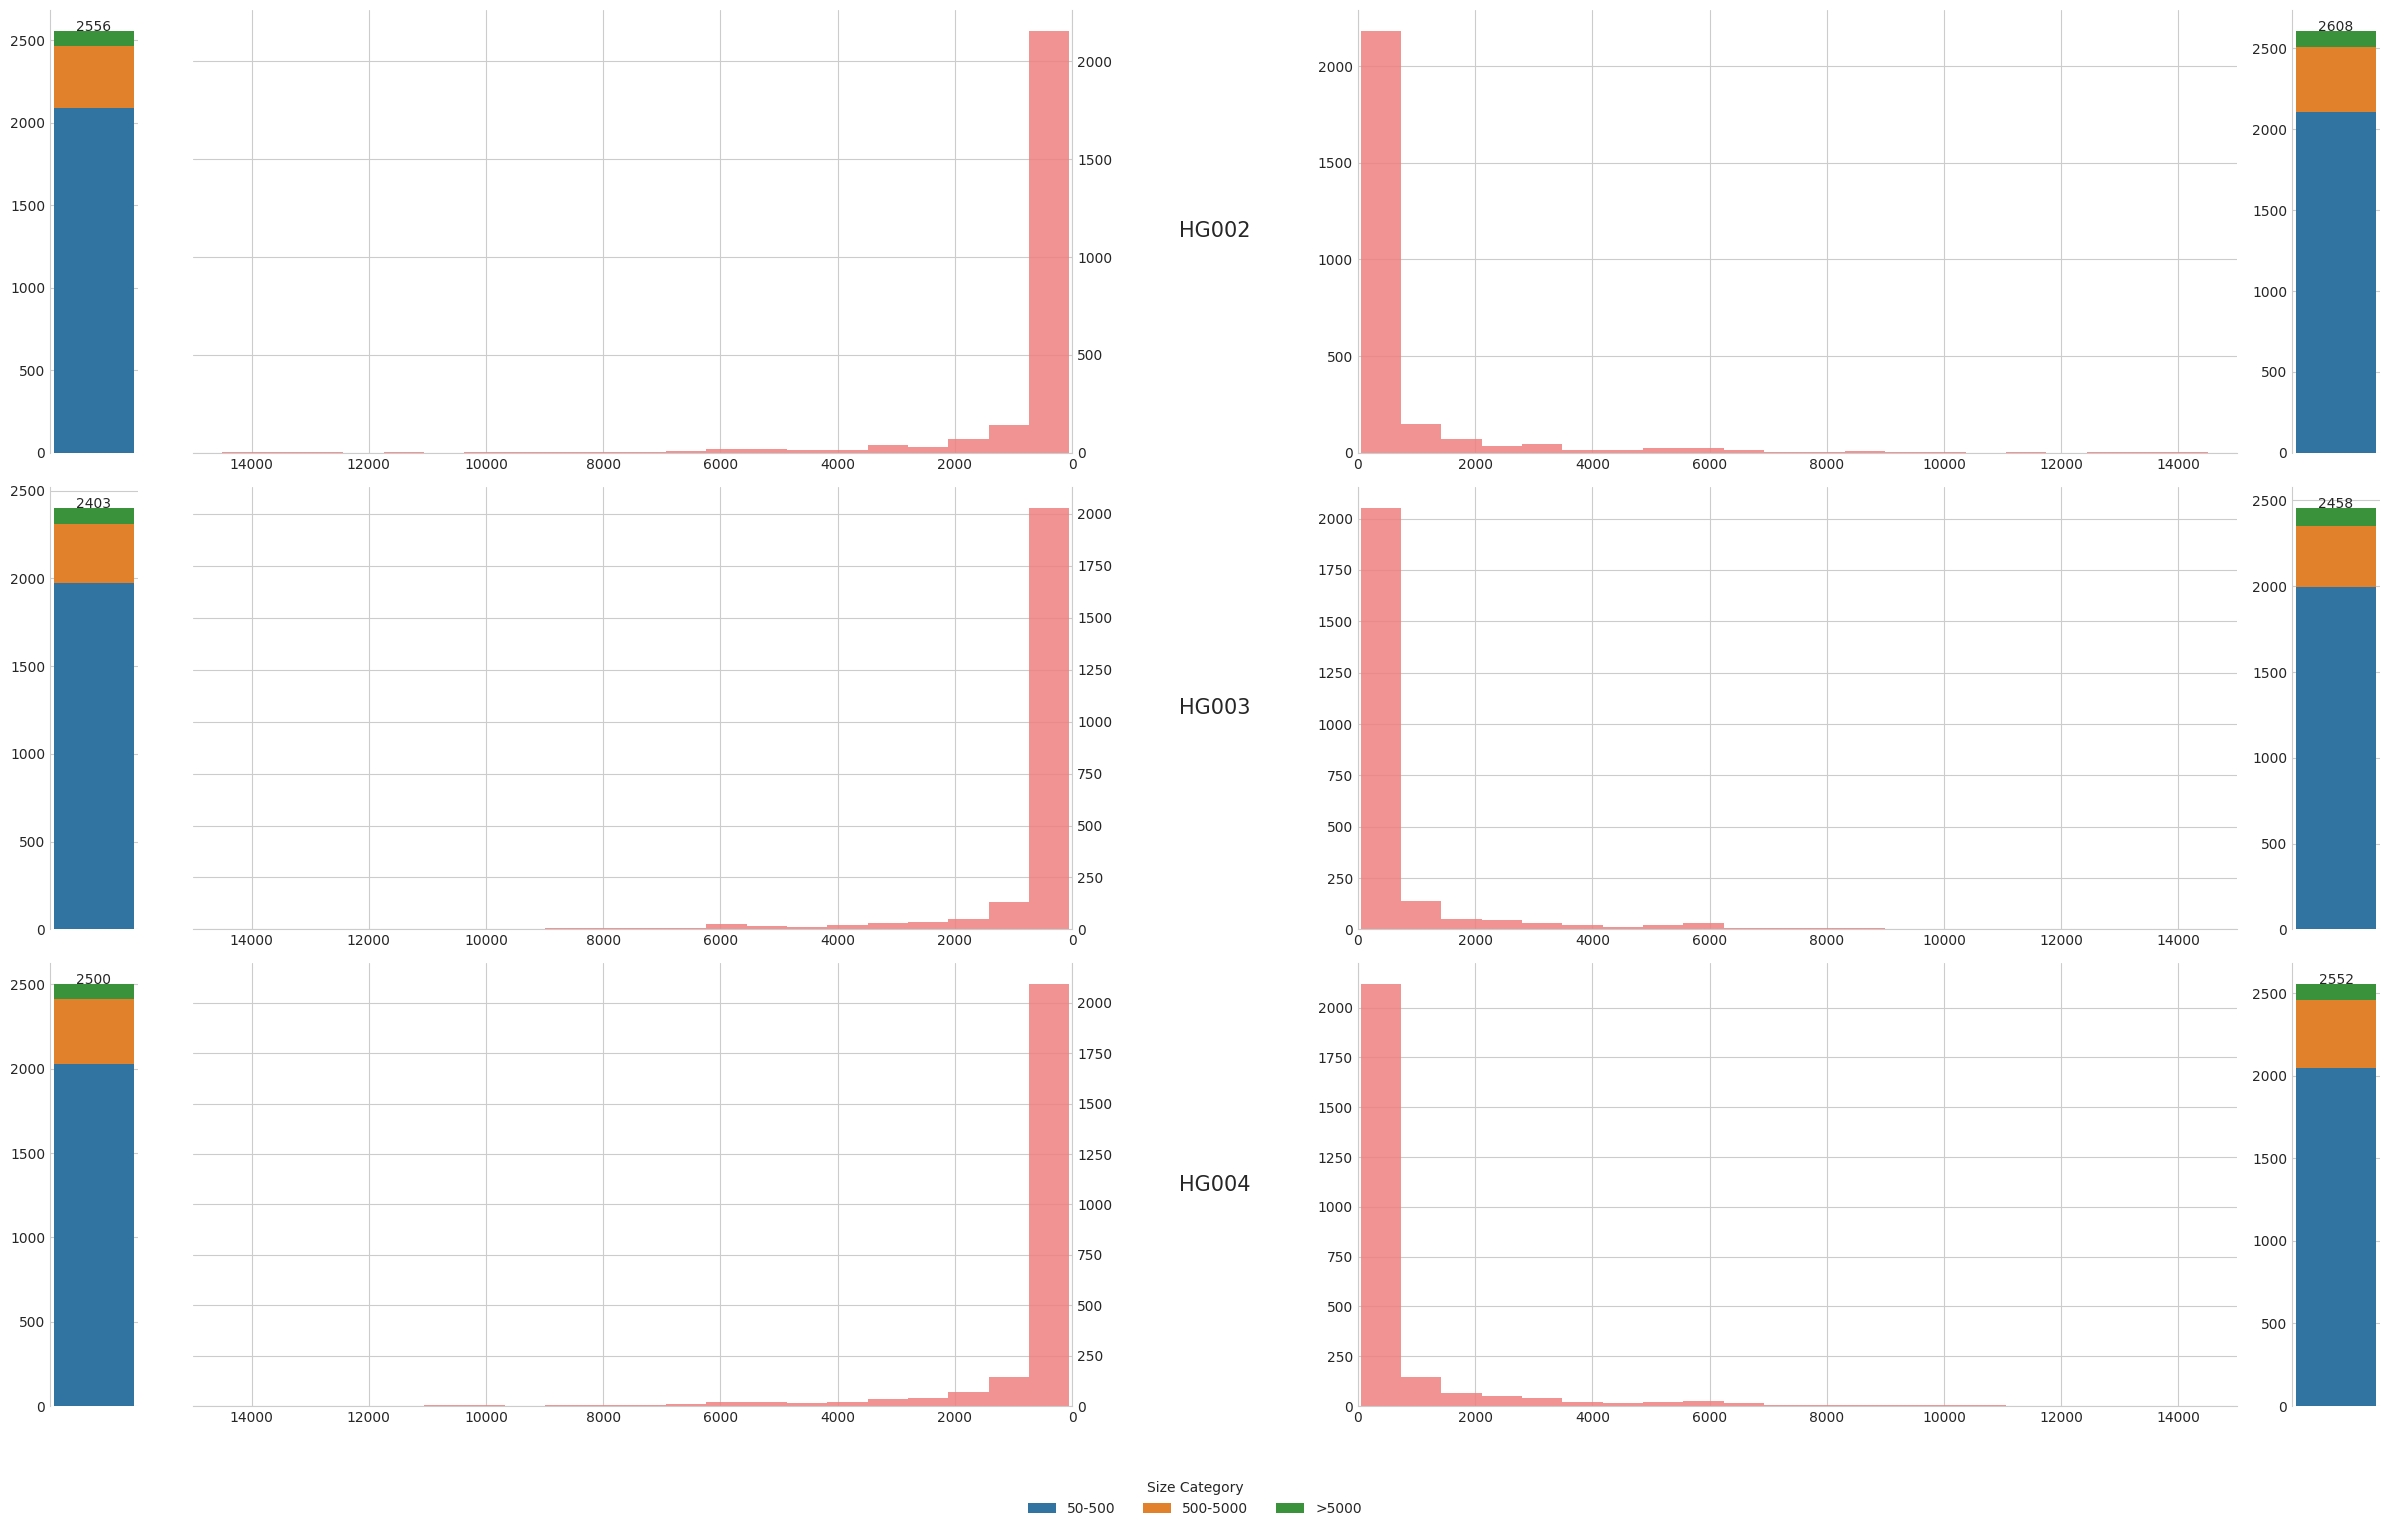

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 17), width_ratios=[0.1, 1, 0.2, 1, 0.1])
fig.subplots_adjust(hspace=0.2, wspace=0.0)

idx = 0
for sample in samples:

    both_sizes, either_sizes = length_dict[sample]["both"], length_dict[sample]["either"]
    both_cat, either_cat = get_category_counts(both_sizes), get_category_counts(either_sizes)

    bins = np.linspace(50, 20000, 30)
    axes[idx, 1].hist(both_sizes, bins=bins, alpha=0.85, label="Both", color='#F08080')
    axes[idx, 1].set_xlim(0, 15000)
    axes[idx, 1].invert_xaxis()
    axes[idx, 1].yaxis.tick_right()
    axes[idx, 1].spines["top"].set_visible(False)
    axes[idx, 1].spines["left"].set_visible(False)

    axes[idx, 3].hist(either_sizes, bins=bins, alpha=0.85, label="Either", color='#F08080')
    axes[idx, 3].set_xlim(0, 15000)
    axes[idx, 3].spines["top"].set_visible(False)
    axes[idx, 3].spines["right"].set_visible(False)

    axes[idx, 2].set_axis_off()
    axes[idx, 2].text(0.5, 0.5, f"{sample}", ha="center", va="center", fontsize=15)

    if idx == 8:
        axes[idx, 1].set_xlabel("Size (bp)")
        axes[idx, 3].set_xlabel("Size (bp)")

    plot_stacked_bar(both_cat, axes[idx, 0])
    plot_stacked_bar(either_cat, axes[idx, 4])

    idx += 1

handles, labels = axes[0,0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower center', title='Size Category', ncols=3)
fig.tight_layout(rect=[0.1, 0.05, 0.9, 0.9])
plt.show()



### Breakpoint uncertainty plot

CIPOS + CIEND SUM only

In [ ]:
root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/{}/{}/{}/60x/"

samples = ["HG002", "HG003", "HG004"]
bench = ["both", "either"]
platforms = ["illumina_150bp"]
callers = ["manta", "delly", "lumpy"]
combinations = list(product(samples, bench, platforms, callers))

uncertainty_dict = {}
for combo in combinations:
    sample, bench, _, caller = combo
    uncertainty_dict.setdefault(sample, {}).setdefault(caller, {}).setdefault(bench, {})
    cur_root = root.format(*combo)
    candidate_fp = f"{cur_root}/candidates.vcf.gz"
    
    caller_vcf = cyvcf2.VCF(candidate_fp)
    called_variants = list(caller_vcf())
    
    tags = ["CIPOS", "CIEND", "CIPOS95", "CIEND95"]
    
    for tag in tags:
        uncertainty_dict[sample][caller][bench][tag] = []
        if not caller_vcf.contains(tag):
            continue
        for variant in called_variants:
            total_uncertainty = sum(map(abs, variant.INFO.get(tag, (0,0))))
            uncertainty_dict[sample][caller][bench][tag].append(total_uncertainty)      

    caller_vcf.close()
    

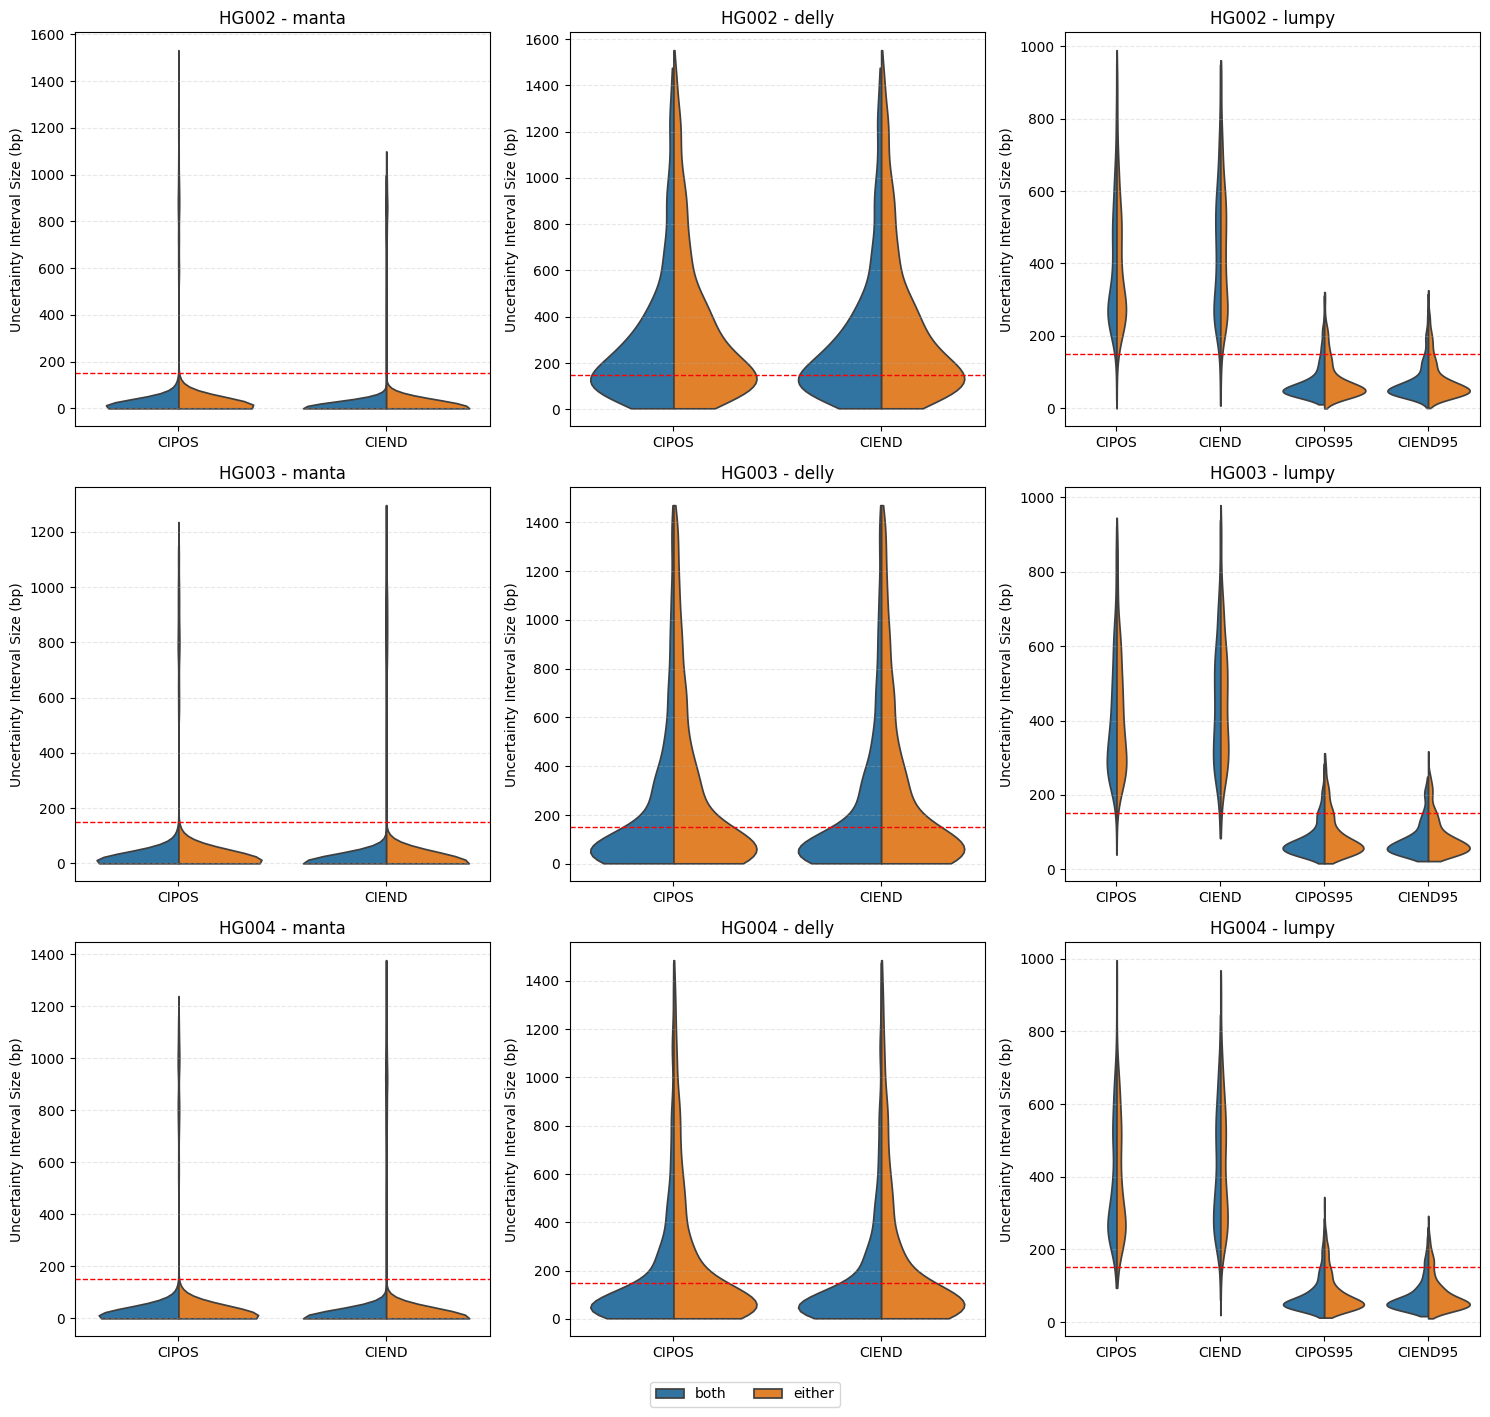

In [ ]:
import seaborn as sns

def create_df_for_plotting(uncertainty_dict):
    dfs = {}
    for sample in uncertainty_dict:
        for caller in uncertainty_dict[sample]:
            key = f"{sample}_{caller}"
            dfs[key] = []
            
            for bench in ['both', 'either']:
                for tag in uncertainty_dict[sample][caller].get(bench, {}):
                    values = uncertainty_dict[sample][caller][bench].get(tag, [])
                    for val in values:
                        dfs[key].append({
                            'tag': tag,
                            'uncertainty': val,
                            'bench': bench
                        })
            
            dfs[key] = pd.DataFrame(dfs[key])
    return dfs

callset_dfs = create_df_for_plotting(uncertainty_dict)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# fig.suptitle('Breakpoint Uncertainty Distributions', fontsize=16)

samples = ["HG002", "HG003", "HG004"]
callers = ["manta", "delly", "lumpy"]
caller_tags = {
    'manta': ['CIPOS', 'CIEND'],
    'delly': ['CIPOS', 'CIEND'],
    'lumpy': ['CIPOS', 'CIEND', 'CIPOS95', 'CIEND95']
}

for i, sample in enumerate(samples):
    for j, caller in enumerate(callers):
        ax = axes[i, j]
        ax.set_title(f"{sample} - {caller}", fontsize=12)
        
        key = f"{sample}_{caller}"
        if key in callset_dfs and not callset_dfs[key].empty:
            df = callset_dfs[key]
            
            # Filter to only include tags relevant for this caller
            df_filtered = df[df['tag'].isin(caller_tags[caller])]
            
            sns.violinplot(
                x='tag', 
                y='uncertainty', 
                hue='bench',
                data=df_filtered, 
                split=True, 
                ax=ax,
                cut=0,
                inner=None
            )
            
            ax.axhline(y=150, color='red', linestyle='--', linewidth=1)
            
            ax.set_ylabel('Uncertainty Interval Size (bp)')
            ax.set_xlabel(None)   
            ax.legend().set_visible(False)
            ax.grid(axis='y', linestyle='--', alpha=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Benchmarking

In [ ]:
import sys
import pysam

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from benchmark import benchmark_callsets, compare_callsets
giab_tier1_bench = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/benchmark_data/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz"

root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/{}/{}/{}/60x/"
bench_root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/{}/structural_variants/benchmark_data/{}/{}_bench_vcf.gz"

samples = ["HG002", "HG003", "HG004"]
bench = ["both", "either"]
platforms = ["illumina_150bp"]
caller = ["manta", "delly", "lumpy"]
combinations = list(product(samples, bench, platforms, caller))

for combo in combinations:
    sample, bench, platform, caller = combo
    cur_root = root.format(*combo)
    bench_fp = bench_root.format(combo[0], combo[1], combo[1])
    
    candidate_fp = f"{cur_root}/candidates.vcf.gz"
    filtered_fp = f"{cur_root}/filtered.vcf.gz"
    
    if not os.path.exists(f"{cur_root}/filtered.bench.vcf.gz"):
        cand_vcf = cyvcf2.VCF(candidate_fp)
        filtered_vcf = cyvcf2.VCF(filtered_fp)
        out_vcf = cyvcf2.Writer(f"{cur_root}/filtered.bench.vcf.gz", filtered_vcf, mode='wz')
        
        var_ids = [v.ID for v in cand_vcf()]
        for v in filtered_vcf():
            if v.ID in var_ids:
                out_vcf.write_record(v)
        
        cand_vcf.close()
        filtered_vcf.close()
        out_vcf.close()
    pysam.tabix_index(f"{cur_root}/filtered.bench.vcf.gz", preset="vcf", force=True)
    


In [ ]:
## Back-to-back barplot (both + either) with number of correctly filtered variants in parentheses
correct_dict, incorrect_dict = {}, {}
perf = {}
count = {}
for combo in combinations:
    
    sample, bench, platform, caller = combo
    cur_root = root.format(*combo)
    bench_fp = bench_root.format(combo[0], combo[1], combo[1])

    candidate_fp = f"{cur_root}/candidates.vcf.gz"
    filtered_fp = f"{cur_root}/filtered.bench.vcf.gz"

    _, tp_comp_old, fp_old, fn_old = benchmark_callsets(bench_fp, candidate_fp)
    _, tp_comp, fp, fn = benchmark_callsets(bench_fp, filtered_fp)
    
    correct_dict[f"{sample}-{caller}-{bench}"] = []
    incorrect_dict[f"{sample}-{caller}-{bench}"] = []
    count[f"{sample}-{caller}-{bench}"] = {}
    perf[f"{sample}-{caller}-{bench}"] = {}
    perf[f"{sample}-{caller}-{bench}"]["before"] = {
        "precision": len(tp_comp_old) / (len(tp_comp_old) + len(fp_old)),
        "recall": len(tp_comp_old) / (len(tp_comp_old) + len(fn_old))
    }
    count[f"{sample}-{caller}-{bench}"]["before"] = {"tp": len(tp_comp_old), "fp": len(fp_old), "fn": len(fn_old)}
    
    perf[f"{sample}-{caller}-{bench}"]["after"] = {
        "precision": len(tp_comp) / (len(tp_comp) + len(fp)),
        "recall": len(tp_comp) / (len(tp_comp) + len(fn))
    }
    count[f"{sample}-{caller}-{bench}"]["after"] = {"tp": len(tp_comp), "fp": len(fp), "fn": len(fn)}
                                            
    for ov in fp_old:
        found = False
        for nv in fp:
            if ov == nv:
                found = True
                break
        if not found:
            correct_dict[f"{sample}-{caller}-{bench}"].append(ov)
    
    for ov in tp_comp_old:
        found = False
        for nv in tp_comp:
            if ov == nv:
                found = True
                break
        if not found:
            incorrect_dict[f"{sample}-{caller}-{bench}"].append(ov)
    print(f"Done processing {sample} {caller} callset with bench {bench}")

Total TP (comp): 1712
Total FP: 195
Total FN: 844
Total TP (comp): 1710
Total FP: 190
Total FN: 846
Done processing HG002 manta callset with bench both
Total TP (comp): 415
Total FP: 148
Total FN: 2141
Total TP (comp): 415
Total FP: 143
Total FN: 2141
Done processing HG002 delly callset with bench both
Total TP (comp): 424
Total FP: 112
Total FN: 2132
Total TP (comp): 424
Total FP: 106
Total FN: 2132
Done processing HG002 lumpy callset with bench both
Total TP (comp): 1746
Total FP: 236
Total FN: 862
Total TP (comp): 1746
Total FP: 221
Total FN: 862
Done processing HG002 manta callset with bench either
Total TP (comp): 436
Total FP: 400
Total FN: 2172
Total TP (comp): 435
Total FP: 307
Total FN: 2173
Done processing HG002 delly callset with bench either
Total TP (comp): 446
Total FP: 232
Total FN: 2162
Total TP (comp): 445
Total FP: 180
Total FN: 2163
Done processing HG002 lumpy callset with bench either
Total TP (comp): 1534
Total FP: 212
Total FN: 869
Total TP (comp): 1534
Total FP: 

In [97]:
## Tabulate results 
count_df = pd.DataFrame.from_dict(count, orient="index")
result1 = pd.json_normalize(count_df["before"]).merge(pd.json_normalize(count_df["after"]), left_index=True, right_index=True, suffixes=("_before", "_after")).set_index(count_df.index)
result1["filter score"] = ((result1["fp_before"] - result1["fp_after"]) / (result1["fp_before"] - result1["fp_after"] + result1["tp_before"] - result1["tp_after"])).round(3)

perf_df = pd.DataFrame.from_dict(perf, orient="index")
result2 = pd.json_normalize(perf_df["before"]).merge(pd.json_normalize(perf_df["after"]), left_index=True, right_index=True, suffixes=("_before", "_after")).set_index(perf_df.index).round(3)
result2["filter score"] = ((result1["fp_before"] - result1["fp_after"]) / (result1["fp_before"] - result1["fp_after"] + result1["tp_before"] - result1["tp_after"])).round(3)
(result1["fp_before"] - result1["fp_after"]) / result1["fp_before"]


HG002-manta-both      0.025641
HG002-delly-both      0.033784
HG002-lumpy-both      0.053571
HG002-manta-either    0.063559
HG002-delly-either    0.232500
HG002-lumpy-either    0.224138
HG003-manta-both      0.028302
HG003-delly-both      0.005348
HG003-lumpy-both      0.021429
HG003-manta-either    0.088803
HG003-delly-either    0.218679
HG003-lumpy-either    0.178295
HG004-manta-both      0.048232
HG004-delly-both      0.021622
HG004-lumpy-both      0.049645
HG004-manta-either    0.072626
HG004-delly-either    0.206349
HG004-lumpy-either    0.161943
dtype: float64

In [ ]:
def count_reasons(var_pool, *variants):
    reasons = {"wthap": 0, "muthap": 0, "het": 0}
    for v in variants:
        for pv in var_pool:
            if pv.CHROM == v[0] and pv.POS == v[1] and pv.REF == v[2] and pv.ALT[0] == v[3]:
                reasons[pv.FILTER] += 1
                break
    return reasons

In [ ]:
assert correct_dict.keys() == incorrect_dict.keys()

all_results = {}
labels = []
for combo in combinations:
    sample, bench, platform, caller = combo
    cur_root = root.format(*combo)
    bench_fp = bench_root.format(combo[0], combo[1], combo[1])
    labels.append(f"{sample}-{caller}-{bench}")
    
    candidate_fp = f"{cur_root}/candidates.vcf.gz"
    filtered_fp = f"{cur_root}/filtered.bench.vcf.gz"
    filtered_vcf = cyvcf2.VCF(filtered_fp)
    variant_pool = list(filtered_vcf())
    
    cur_correct = [v[1] for v in correct_dict[f"{sample}-{caller}-{bench}"]]
    cur_incorrect = [v[1] for v in incorrect_dict[f"{sample}-{caller}-{bench}"]]

    all_results[f"{sample}-{caller}-{bench}"] = {}
    all_results[f"{sample}-{caller}-{bench}"]["correct"] = count_reasons(variant_pool, *cur_correct)
    all_results[f"{sample}-{caller}-{bench}"]["incorrect"] = count_reasons(variant_pool, *cur_incorrect)
                         
    filtered_vcf.close()

df = pd.DataFrame.from_dict(all_results, orient="index")

In [ ]:
def plot_reasons(df, ax, invert=False):
    
    bar_width = 0.15
    r1 = np.arange(len(df.index))
    
    # Extract values for each category and status
    wthap_correct = [d['wthap'] for d in df['correct']]
    muthap_correct = [d['muthap'] for d in df['correct']]
    het_correct = [d['het'] for d in df['correct']]

    wthap_incorrect = [d['wthap'] for d in df['incorrect']]
    muthap_incorrect = [d['muthap'] for d in df['incorrect']]
    het_incorrect = [d['het'] for d in df['incorrect']]
    
    colors = {
        'wthap_correct': '#0173B2',    # blue
        'wthap_incorrect': '#80B9D8',  # light blue
        'muthap_correct': '#029E73',   # green
        'muthap_incorrect': '#7FD3B9', # light green
        'het_correct': '#D55E00',      # red-orange
        'het_incorrect': '#EAA993'     # light red-orange
    }
    
    # Plot bars with slightly larger spacing between categories
    ax.barh(r1 - 1.2 * bar_width, wthap_correct, height=bar_width, label='wthap correct', 
            color=colors['wthap_correct'], edgecolor='white', linewidth=0.5)
    ax.barh(r1, muthap_correct, height=bar_width, label='muthap correct', 
            color=colors['muthap_correct'], edgecolor='white', linewidth=0.5)
    ax.barh(r1 + 1.2 * bar_width, het_correct, height=bar_width, label='het correct', 
            color=colors['het_correct'], edgecolor='white', linewidth=0.5)

    # Plot incorrect bars stacked on correct bars
    ax.barh(r1 - 1.2 * bar_width, wthap_incorrect, left=wthap_correct, height=bar_width, 
            label='wthap incorrect', color=colors['wthap_incorrect'], edgecolor='white', linewidth=0.5)
    ax.barh(r1, muthap_incorrect, left=muthap_correct, height=bar_width, 
            label='muthap incorrect', color=colors['muthap_incorrect'], edgecolor='white', linewidth=0.5)
    ax.barh(r1 + 1.2 * bar_width, het_incorrect, left=het_correct, height=bar_width, 
            label='het incorrect', color=colors['het_incorrect'], edgecolor='white', linewidth=0.5)

    ax.set_yticks(r1)
    ax.set_yticklabels([])

    ax.set_xlabel('Counts', fontsize=12, fontweight='bold')

    ax.grid(axis='x', linestyle='--', alpha=0.7, zorder=0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    ax.set_facecolor('#F8F8F8')
    ax.set_xlim(left=0)
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.8, length=4)
    ax.tick_params(axis='x', which='major', pad=6)
    
    if invert:
        ax.invert_xaxis()
        ax.get_yaxis().tick_right()
    
    return ax

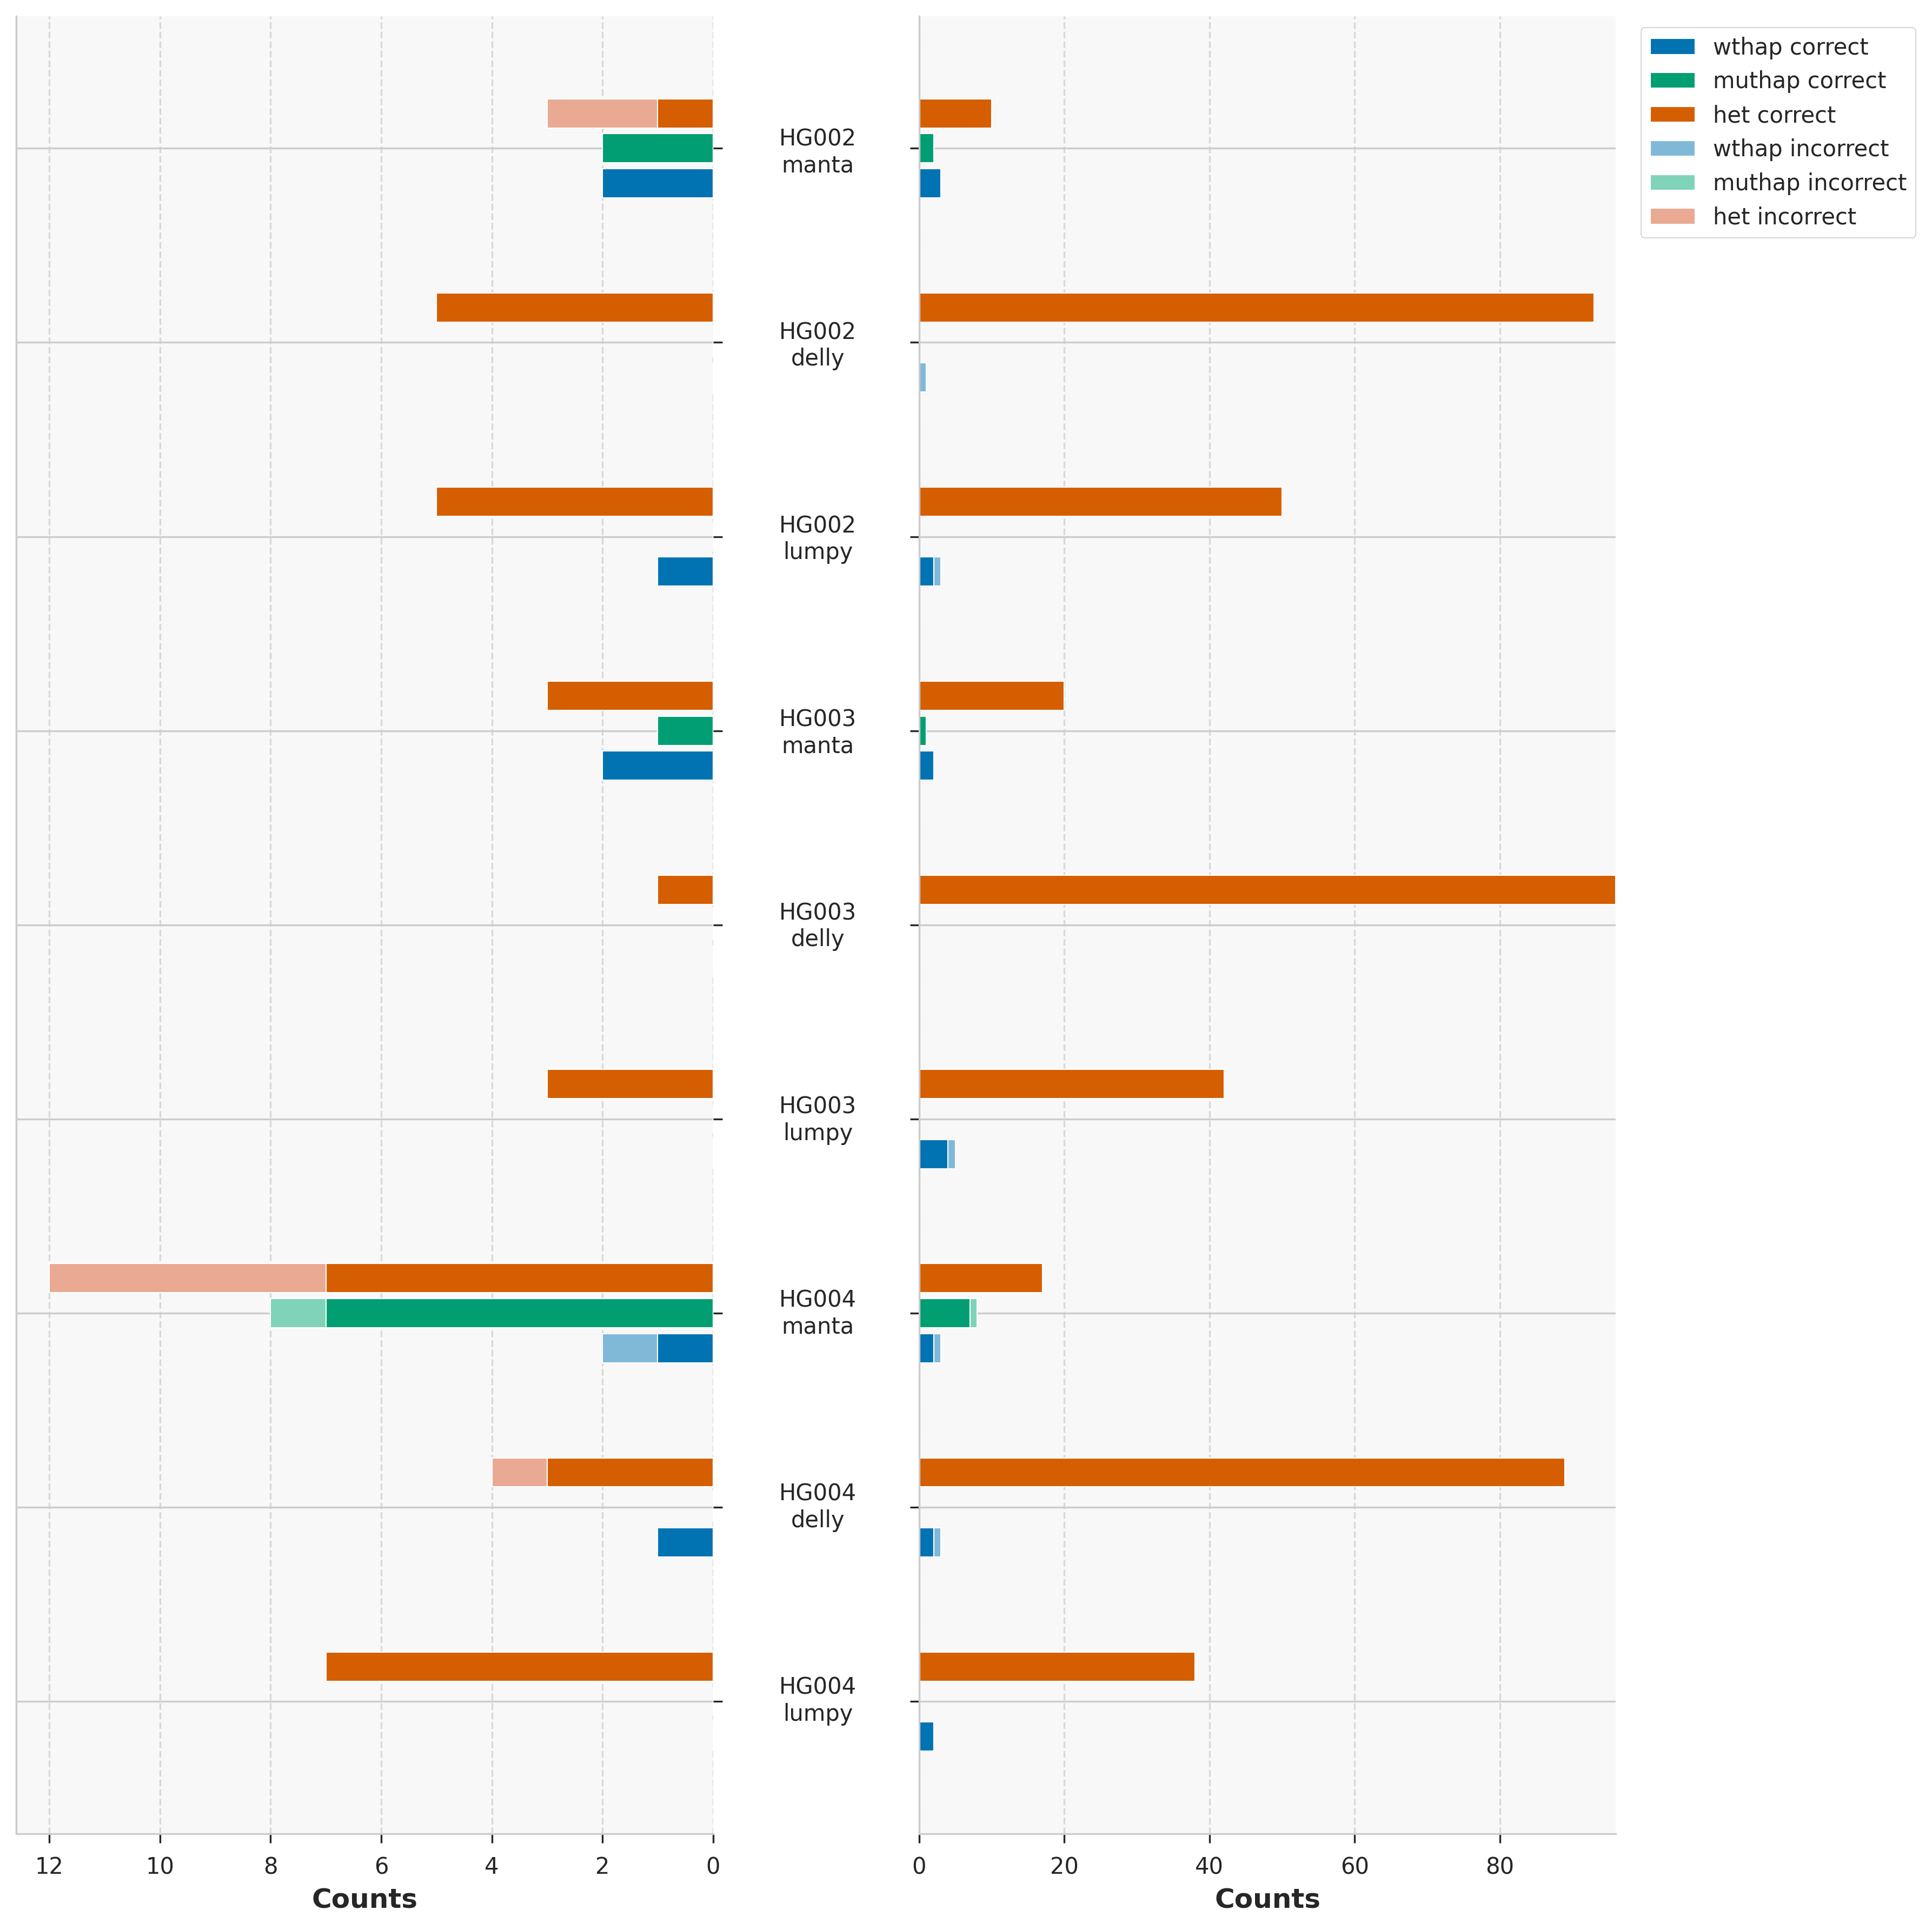

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['axes.linewidth'] = 0.8

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12), dpi=300, width_ratios=[1, 0.2, 1])
both_df = df[df.index.str.contains("both")]
both_df = both_df.iloc[::-1, :]
either_df = df[df.index.str.contains("either")]
either_df = either_df.iloc[::-1, :]
plot_reasons(both_df, axes[0], invert=True)
plot_reasons(either_df, axes[2], invert=False)

axes[1].set_axis_off()
labels = both_df.index.str.replace("-both", "")
for i, label in enumerate(reversed(labels)):
    sample, caller = label.split("-")
    axes[1].text(0.513, 0.925 - i * 0.1065, f"{sample}\n{caller}", ha='center', va='center', fontsize=10)

legend = axes[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, 
                  fontsize=10, framealpha=0.9, edgecolor='lightgray')
legend.get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.show()



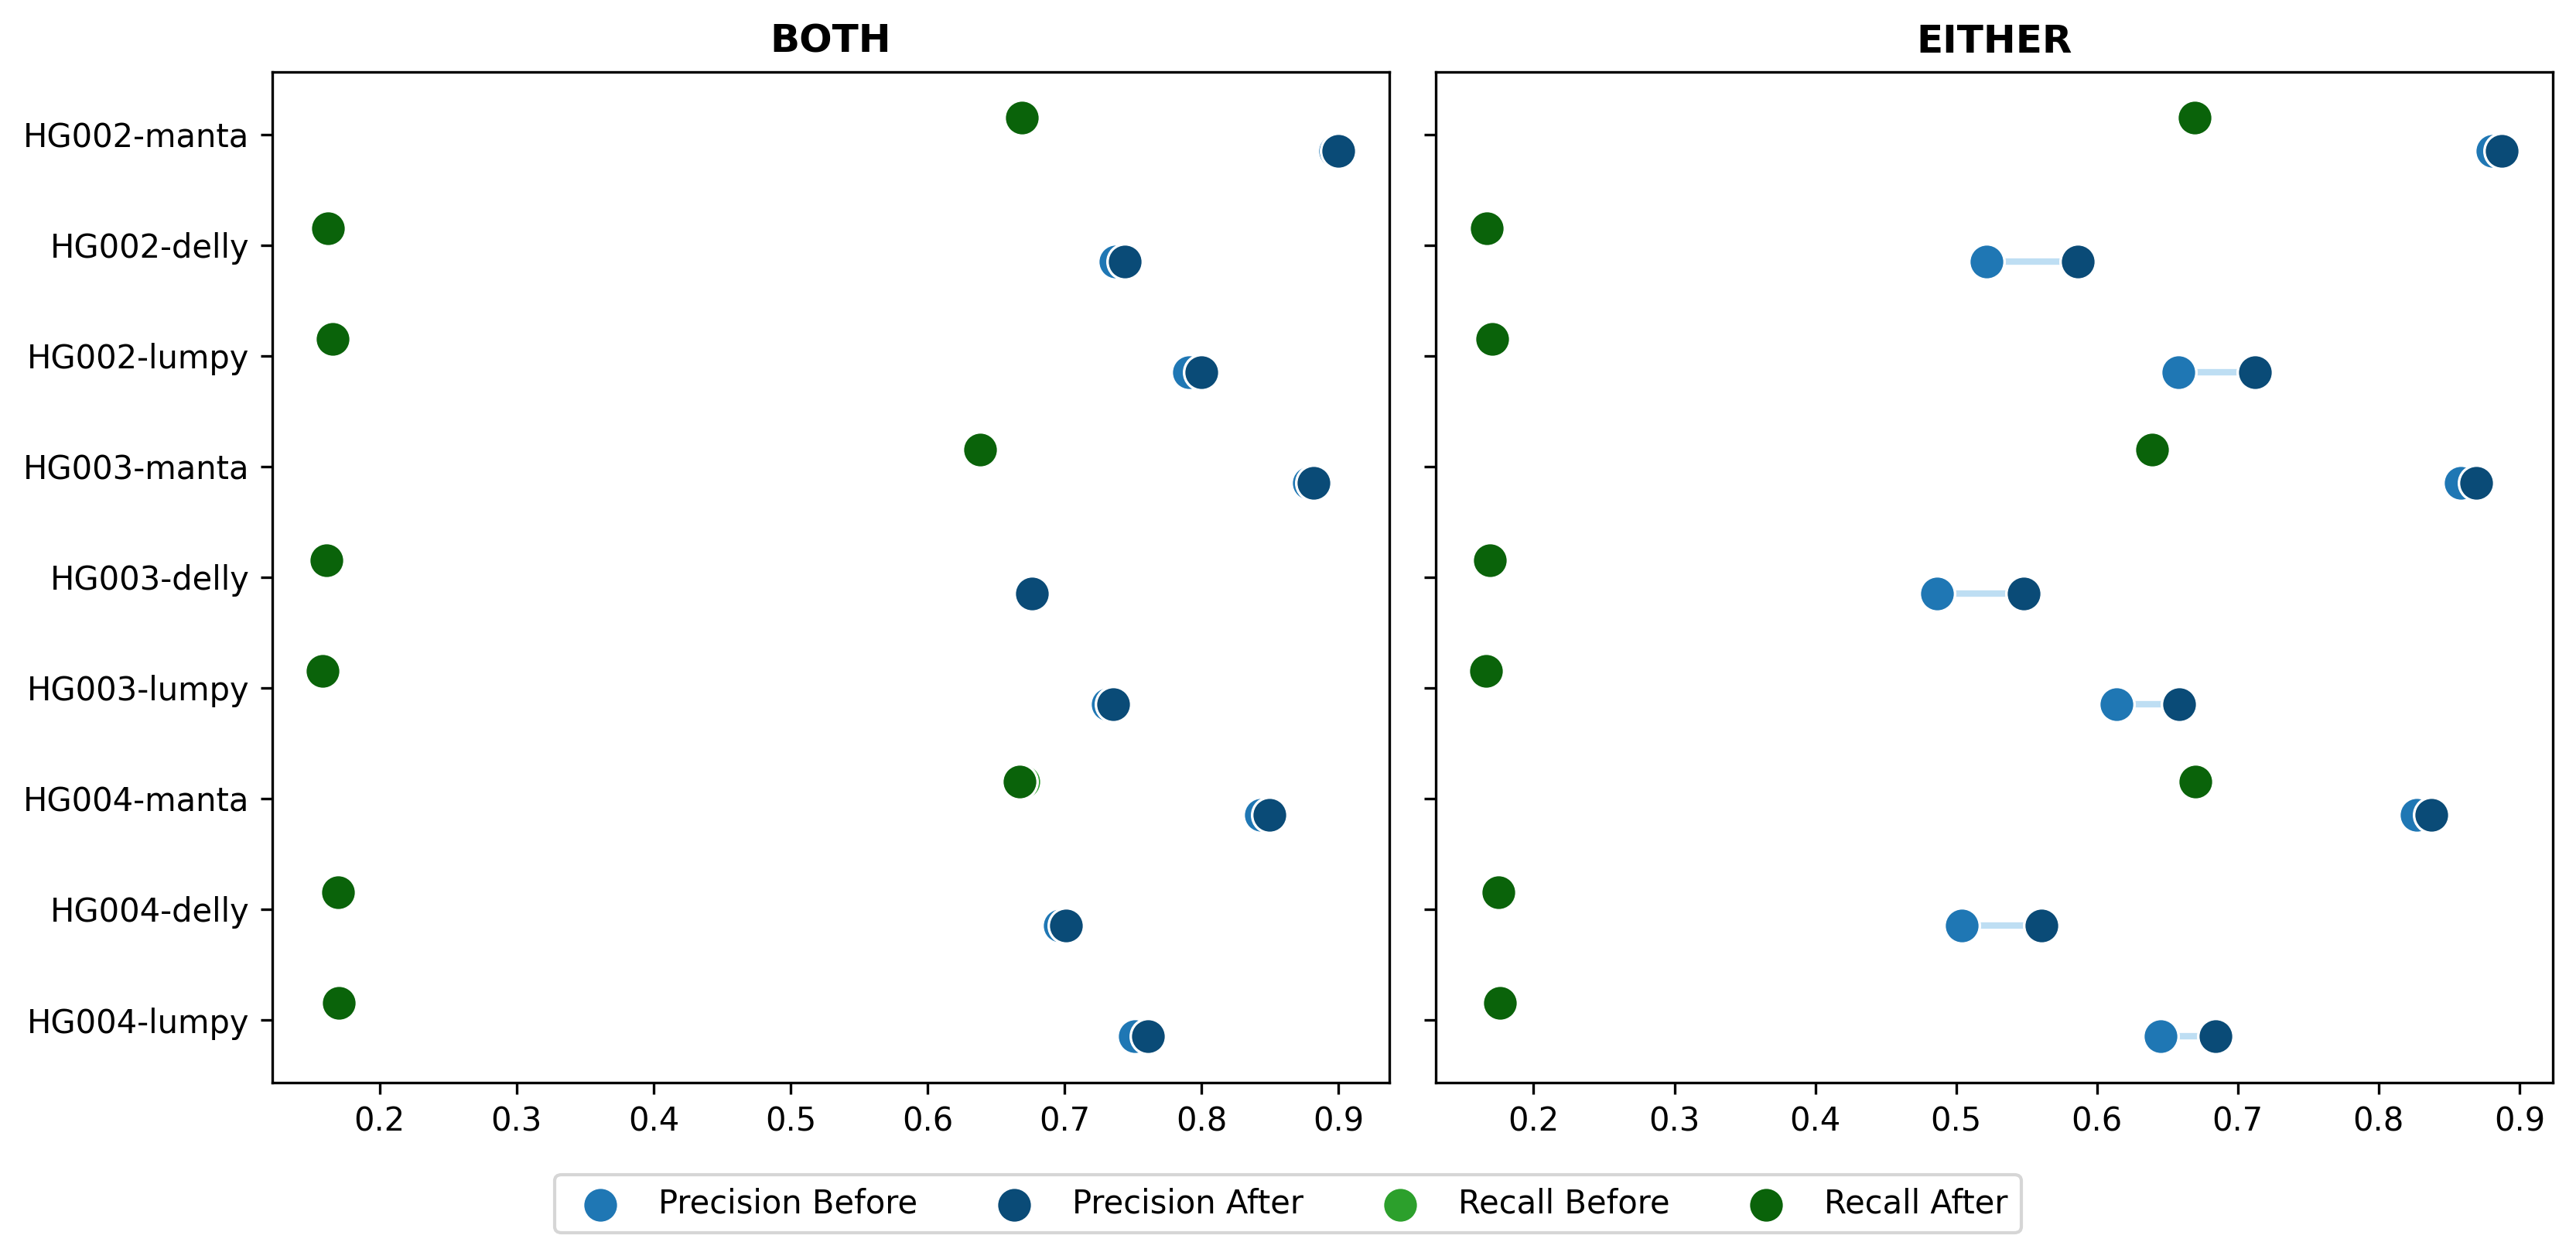

In [ ]:
def plot_dumbbell(df, ax, title=None):
    
    precision_before = [d['precision'] for d in df['before']]
    recall_before = [d['recall'] for d in df['before']]
    precision_after = [d['precision'] for d in df['after']]
    recall_after = [d['recall'] for d in df['after']]
    
    y_pos = np.arange(df.shape[0])
    
    colors = {
        'precision_before': '#1F77B4',  # Blue
        'precision_after': '#0A4B77',   # Dark blue
        'recall_before': '#2CA02C',     # Green
        'recall_after': '#0A630A',      # Dark green
        'line_precision': '#AED6F1',    # Light blue
        'line_recall': '#A9DFBF'        # Light green
    }
    
    ax.hlines(y=y_pos - 0.15, xmin=precision_before, xmax=precision_after, 
          color=colors['line_precision'], alpha=0.8, linewidth=2, zorder=1)
    ax.scatter(precision_before, y_pos - 0.15, color=colors['precision_before'], 
               label='Precision Before', s=120, zorder=3, edgecolor='white', linewidth=0.8)
    ax.scatter(precision_after, y_pos - 0.15, color=colors['precision_after'], 
               label='Precision After', s=120, zorder=3, edgecolor='white', linewidth=0.8)
    
    ax.hlines(y=y_pos + 0.15, xmin=recall_before, xmax=recall_after, 
          color=colors['line_recall'], alpha=0.8, linewidth=2, zorder=1)
    ax.scatter(recall_before, y_pos + 0.15, color=colors['recall_before'], 
               label='Recall Before', s=120, zorder=3, edgecolor='white', linewidth=0.8)
    ax.scatter(recall_after, y_pos + 0.15, color=colors['recall_after'], 
               label='Recall After', s=120, zorder=3, edgecolor='white', linewidth=0.8)
    
    ax.grid(axis="x", linewidth=0)
    ax.set_yticks(range(0, 9))
    ax.set_yticklabels(df.index.str.replace("-either", ""))
    
    ax.spines['top'].set_visible(0.8)
    ax.spines['right'].set_visible(0.8)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    if title:
        ax.set_title(title, fontweight="bold")
    
    return ax

df = pd.DataFrame.from_dict(perf, orient="index")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True, dpi=300)

both_perf, either_perf = df[df.index.str.contains("both")], df[df.index.str.contains("either")]

plot_dumbbell(both_perf.iloc[::-1, :], axes[0], title="BOTH")
plot_dumbbell(either_perf.iloc[::-1, :], axes[1], title="EITHER")

handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower center', title='', ncols=4)
fig.tight_layout(rect=[0.1, 0.05, 0.9, 0.9])
plt.show()

### Different coverages

In [ ]:
callers = ["manta", "delly", "lumpy"]
depths = ["20x", "30x", "60x"]

root = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{}/{}/" ## sample, caller, depth

reason_counts = {}
for caller in callers:
    for depth in depths:
        reason_counts.setdefault(caller, {}).setdefault(depth, {})
        reason_counts[caller][depth] = {"wthap": 0, "muthap": 0, "het": 0}
        
        cur_root = root.format(caller, depth)
        filtered_fp = f"{cur_root}/filtered.vcf.gz"
        
        filtered_vcf = cyvcf2.VCF(filtered_fp)
        
        for variant in filtered_vcf():
            if variant.FILTER in ["wthap", "muthap", "het"]:
                reason_counts[caller][depth][variant.FILTER] += 1
                
        filtered_vcf.close()

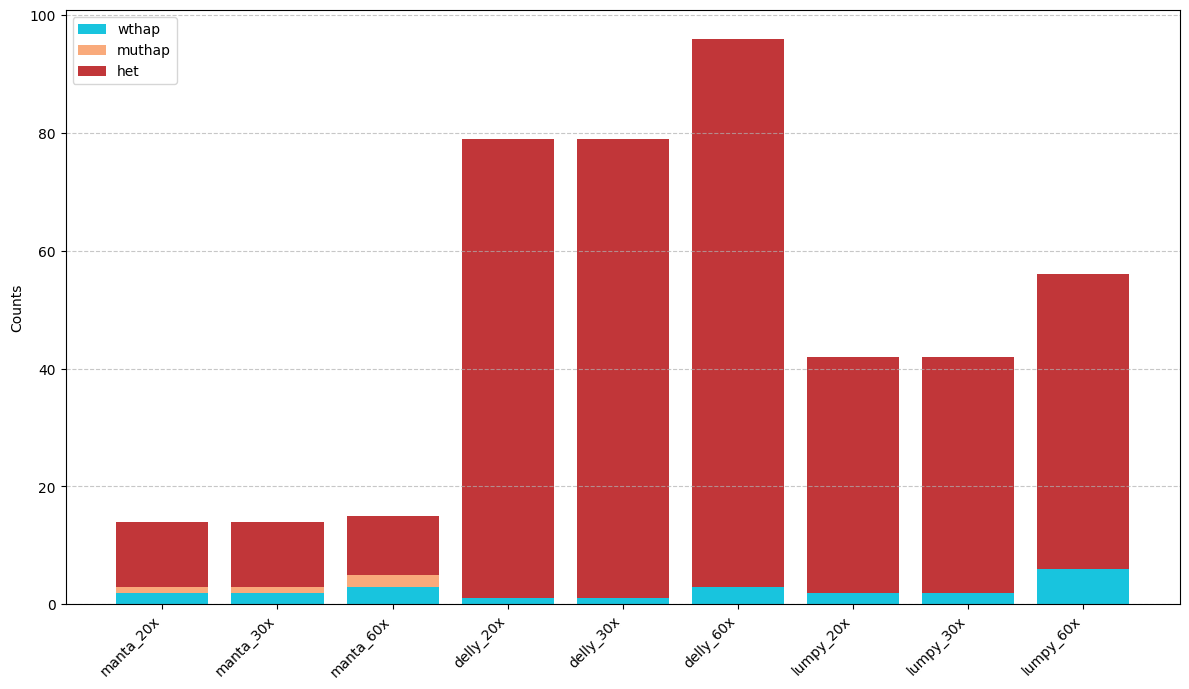

In [ ]:
labels = [f"{caller}_{depth}" for caller in callers for depth in depths]
wthap_counts = [reason_counts[caller][depth]["wthap"] for caller in callers for depth in depths]
muthap_counts = [reason_counts[caller][depth]["muthap"] for caller in callers for depth in depths]
het_counts = [reason_counts[caller][depth]["het"] for caller in callers for depth in depths]

x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(x, wthap_counts, label='wthap', color='#18C4DE')
ax.bar(x, muthap_counts, bottom=wthap_counts, label='muthap', color='#F9AA7B')
bottom_het = np.array(wthap_counts) + np.array(muthap_counts)
ax.bar(x, het_counts, bottom=bottom_het, label='het', color='#C13639')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Counts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


### Comparison with Paragraph

In [ ]:
## Build paragraph scripts
manifest_path = "/lustre1/g/paed_yangwl/snakesch/work/svhet/scripts/paragraph/manifest/HG002-illumina_150bp.txt"
paragraph_bin = "/lustre1/g/paed_yangwl/snakesch/tools/paragraph/bin/multigrmpy.py"
reference = "/group/paed_yangwl/hs37d5/hs37d5.fa"

script_path = os.path.join("/lustre1/g/paed_yangwl/snakesch/work/svhet/scripts/paragraph", "run_paragraph.sh")

callers = ["manta", "delly", "lumpy"]

with open(script_path, "w") as outfs:
    outfs.write("#!/bin/bash\n")
    for caller in callers:
        candidate_vcf_fp = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/candidates.vcf.gz"
        outd = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/paragraph/"
        os.makedirs(outd, exist_ok=True)
        
        if caller == "delly":
            ambiguous_id = "HG002.hs37d5.60x.1"
        else:
            ambiguous_id = "SAMPLE1"
        
        outfs.write(r"{ zgrep ^# " + candidate_vcf_fp + r" | sed -e 's/" + ambiguous_id + r"/HG002/g'; zgrep -v ^# " + candidate_vcf_fp + r"; } | bgzip -c > " + os.path.join(outd, "candidates.reheader.vcf.gz") + "\n")
        
        outfs.write(fr"{paragraph_bin} -r {reference} -m {manifest_path} ")
        outfs.write(fr"-i " + os.path.join(outd, "candidates.reheader.vcf.gz") + " ")
        outfs.write(fr"-o {outd} ")
        outfs.write("--threads 8 --verbose ")
        outfs.write("\n")
        
        paragraph_out = os.path.join(outd, "genotypes.vcf.gz")
        outfs.write(f"tabix -p vcf {paragraph_out}")
        outfs.write("\n")
        
        outfs.write(f"bcftools filter -i 'GT=\"het\"' -Wtbi -Oz -o {paragraph_out.replace('.vcf.gz', '.het.vcf.gz')} {paragraph_out}")
        outfs.write("\n")


In [ ]:
## Benchmarking paragraph callsets

import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from benchmark import benchmark_callsets

callers = ["manta", "delly", "lumpy"]

def classify_rejections(tp_old, tp_new, fp_old, fp_new):
    
    correct, incorrect = [], []
    for ov in tp_old:
        found = False
        for nv in tp_new:
            if ov == nv:
                found = True
                break
        if not found:
            incorrect.append(ov)
    
    for ov in fp_old:
        found = False
        for nv in fp_new:
            if ov == nv:
                found = True
                break
        if not found:
            correct.append(ov)
            
    return correct, incorrect

results = {}

for caller in callers:
    candidate_vcf_fp = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/candidates.vcf.gz"
    svhet_vcf_fp = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/filtered.bench.vcf.gz"
    paragraph_vcf_fp = f"/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/either/illumina_150bp/{caller}/60x/paragraph/genotypes.het.vcf.gz"
    either_bench_vcf_fp = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/benchmark_data/either/either_bench_vcf.gz"
    print("Caller: ", caller)
    results[caller] = {}
    _, tp_cand, fp_cand, fn_cand = benchmark_callsets(either_bench_vcf_fp, candidate_vcf_fp)
    _, tp_svhet, fp_svhet, fn_svhet = benchmark_callsets(either_bench_vcf_fp, svhet_vcf_fp)
    _, tp_paragraph, fp_paragraph, fn_paragraph = benchmark_callsets(either_bench_vcf_fp, paragraph_vcf_fp)
    
    results[caller]["tp-cand"] = len(tp_cand)
    results[caller]["fp-cand"] = len(fp_cand)
    results[caller]["fn-cand"] = len(fn_cand)
    results[caller]["tp-svhet"] = len(tp_svhet)
    results[caller]["fp-svhet"] = len(fp_svhet)
    results[caller]["fn-svhet"] = len(fn_svhet)
    results[caller]["tp-paragraph"] = len(tp_paragraph)
    results[caller]["fp-paragraph"] = len(fp_paragraph)
    results[caller]["fn-paragraph"] = len(fn_paragraph)
    



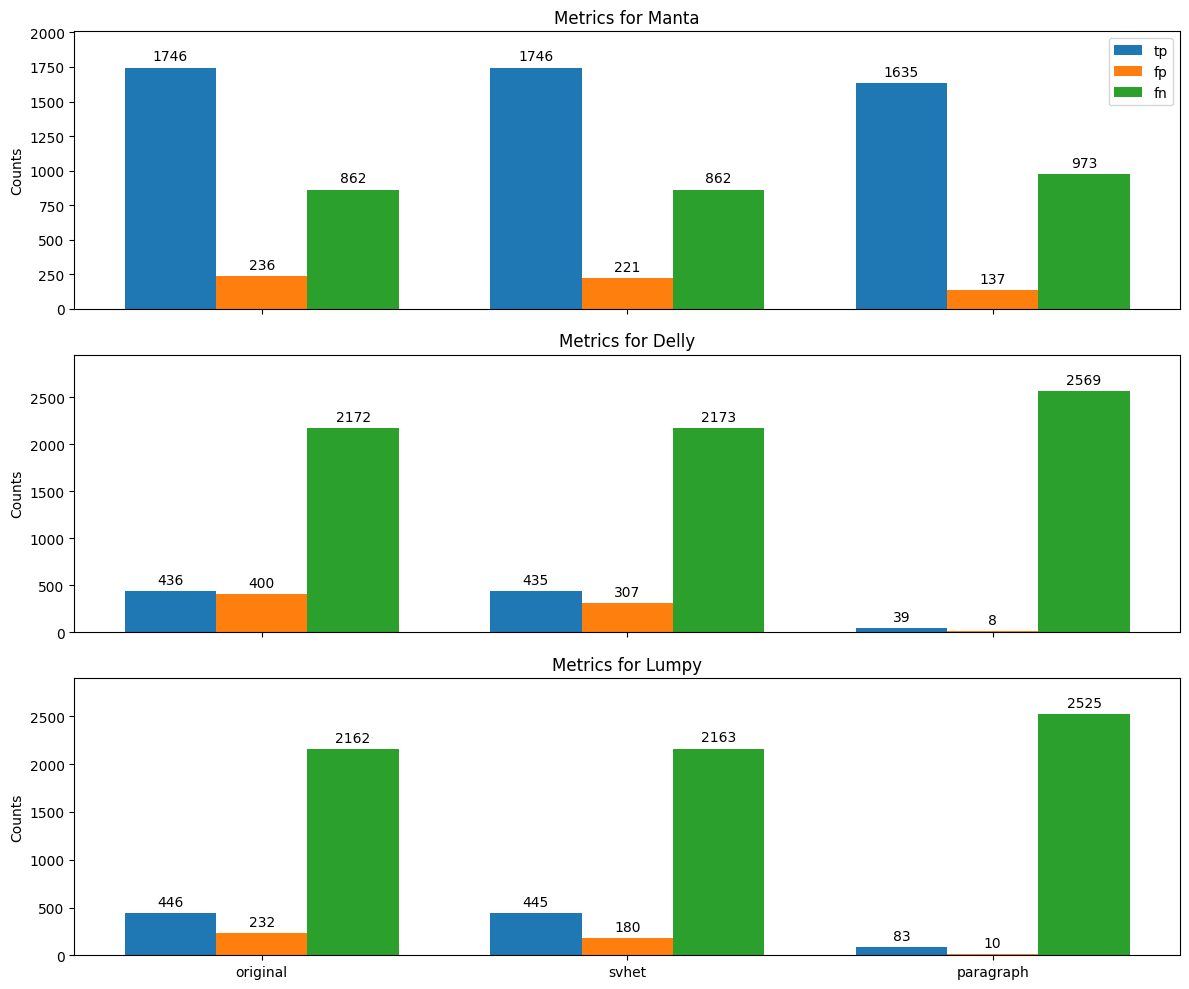

In [ ]:
df = pd.DataFrame.from_dict(results, orient="index")

colors = {'tp': '#1f77b4', 'fp': '#ff7f0e', 'fn': '#2ca02c'}

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

metric_groups = ['cand', 'svhet', 'paragraph']

for i, caller in enumerate(df.index):
    ax = axes[i]
    
    cand_data = [df.loc[caller, 'tp-cand'], df.loc[caller, 'fp-cand'], df.loc[caller, 'fn-cand']]
    svhet_data = [df.loc[caller, 'tp-svhet'], df.loc[caller, 'fp-svhet'], df.loc[caller, 'fn-svhet']]
    paragraph_data = [df.loc[caller, 'tp-paragraph'], df.loc[caller, 'fp-paragraph'], df.loc[caller, 'fn-paragraph']]
    
    x = np.arange(3) 
    width = 0.25 
    
    bars_tp = ax.bar(x - width, [cand_data[0], svhet_data[0], paragraph_data[0]], width, 
           label='tp' if i == 0 else "", color=colors['tp'])
    bars_fp = ax.bar(x, [cand_data[1], svhet_data[1], paragraph_data[1]], width, 
           label='fp' if i == 0 else "", color=colors['fp'])
    bars_fn = ax.bar(x + width, [cand_data[2], svhet_data[2], paragraph_data[2]], width, 
           label='fn' if i == 0 else "", color=colors['fn'])
    
    all_values = cand_data + svhet_data + paragraph_data
    max_value = max(all_values)
    ax.set_ylim(0, max_value * 1.15)
    
    for bars in [bars_tp, bars_fp, bars_fn]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    ax.set_title(f'Metrics for {caller.capitalize()}')
    ax.set_ylabel('Counts')
    ax.set_xticks(x)
    ax.set_xticklabels(['original', 'svhet', 'paragraph'])
    ax.grid(False)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
result3 = pd.concat([
    pd.json_normalize(results["manta"]),
    pd.json_normalize(results["delly"]),
    pd.json_normalize(results["lumpy"])
])

result3.index = ['manta', 'delly', 'lumpy']
result3["precision_before"] = result3["tp-cand"] / (result3["tp-cand"] + result3["fp-cand"])
result3["recall_before"] = result3["tp-cand"] / (result3["tp-cand"] + result3["fn-cand"])
result3["precision_svhet"] = result3["tp-svhet"] / (result3["tp-svhet"] + result3["fp-svhet"])
result3["recall_svhet"] = result3["tp-svhet"] / (result3["tp-svhet"] + result3["fn-svhet"])
result3["precision_paragraph"] = result3["tp-paragraph"] / (result3["tp-paragraph"] + result3["fp-paragraph"])
result3["recall_paragraph"] = result3["tp-paragraph"] / (result3["tp-paragraph"] + result3["fn-paragraph"])
result3["FS_svhet"] = ((result3["fp-cand"] - result3["fp-svhet"]) / (result3["fp-cand"] - result3["fp-svhet"] + result3["tp-cand"] - result3["tp-svhet"])).round(3)
result3["FS_paragraph"] = ((result3["fp-cand"] - result3["fp-paragraph"]) / (result3["fp-cand"] - result3["fp-paragraph"] + result3["tp-cand"] - result3["tp-paragraph"])).round(3)

result3.iloc[:, 9:].round(3)

,precision_before,recall_before,precision_svhet,recall_svhet,precision_paragraph,recall_paragraph,FS_svhet,FS_paragraph
manta,0.881,0.669,0.888,0.669,0.923,0.627,1.000,0.471
delly,0.522,0.167,0.586,0.167,0.830,0.015,0.989,0.497
lumpy,0.658,0.171,0.712,0.171,0.892,0.032,0.981,0.379


### Time profiles

In [ ]:
import re

def extract_walltime_peak_rss(file_path: str):

    walltime_minutes = None
    peak_rss_gb = None
    
    try:
        with open(file_path, 'r') as file:
            time_output = file.read()
        
        # Extract elapsed (wall clock) time in format h:mm:ss or m:ss
        walltime_match = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): ([0-9:.]+)', time_output)
        if walltime_match:
            time_str = walltime_match.group(1)
            
            # Convert time string to total minutes
            parts = time_str.split(':')
            if len(parts) == 3:  # h:mm:ss format
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = float(parts[2])
                walltime_minutes = (hours * 60) + minutes + (seconds / 60)
            elif len(parts) == 2:  # m:ss format
                minutes = int(parts[0])
                seconds = float(parts[1])
                walltime_minutes = minutes + (seconds / 60)
            else:
                raise ValueError(f"Invalid time format: {time_str}")
        
        # Extract Maximum resident set size (kbytes) and convert to GB
        peak_rss_match = re.search(r'Maximum resident set size \(kbytes\): (\d+)', time_output)
        if peak_rss_match:
            peak_rss_kb = int(peak_rss_match.group(1))
            peak_rss_gb = peak_rss_kb / 1000000
            
    except Exception as e:
        return str(e), None
    
    return walltime_minutes, peak_rss_gb

In [123]:
time_out = "/lustre1/g/paed_yangwl/snakesch/data/svhet2/HG002/structural_variants/time_profiles"

time_dict = {}
memory_dict = {}
for root, dirs, files in os.walk(time_out):
    for file in files:
        if not "150bp" in file:
            continue
        
        fp = os.path.join(root, file)
        time, rss = extract_walltime_peak_rss(fp)
        
        if "60x" in file:
            _, bench, caller, *_ = file.split("_")
            if bench == "both":
                continue
            
            time_dict.setdefault("60x", {}).setdefault(bench, {})
            memory_dict.setdefault("60x", {}).setdefault(bench, {})
            time_dict["60x"][bench][caller] = time
            memory_dict["60x"][bench][caller] = rss
        elif "30x" in file or "20x" in file:
            _, caller, _, depth = file.removesuffix(".txt").split("_")
            
            time_dict.setdefault(depth, {}).setdefault("either", {})
            memory_dict.setdefault(depth, {}).setdefault("either", {})
            time_dict[depth]["either"][caller] = time
            memory_dict[depth]["either"][caller] = rss

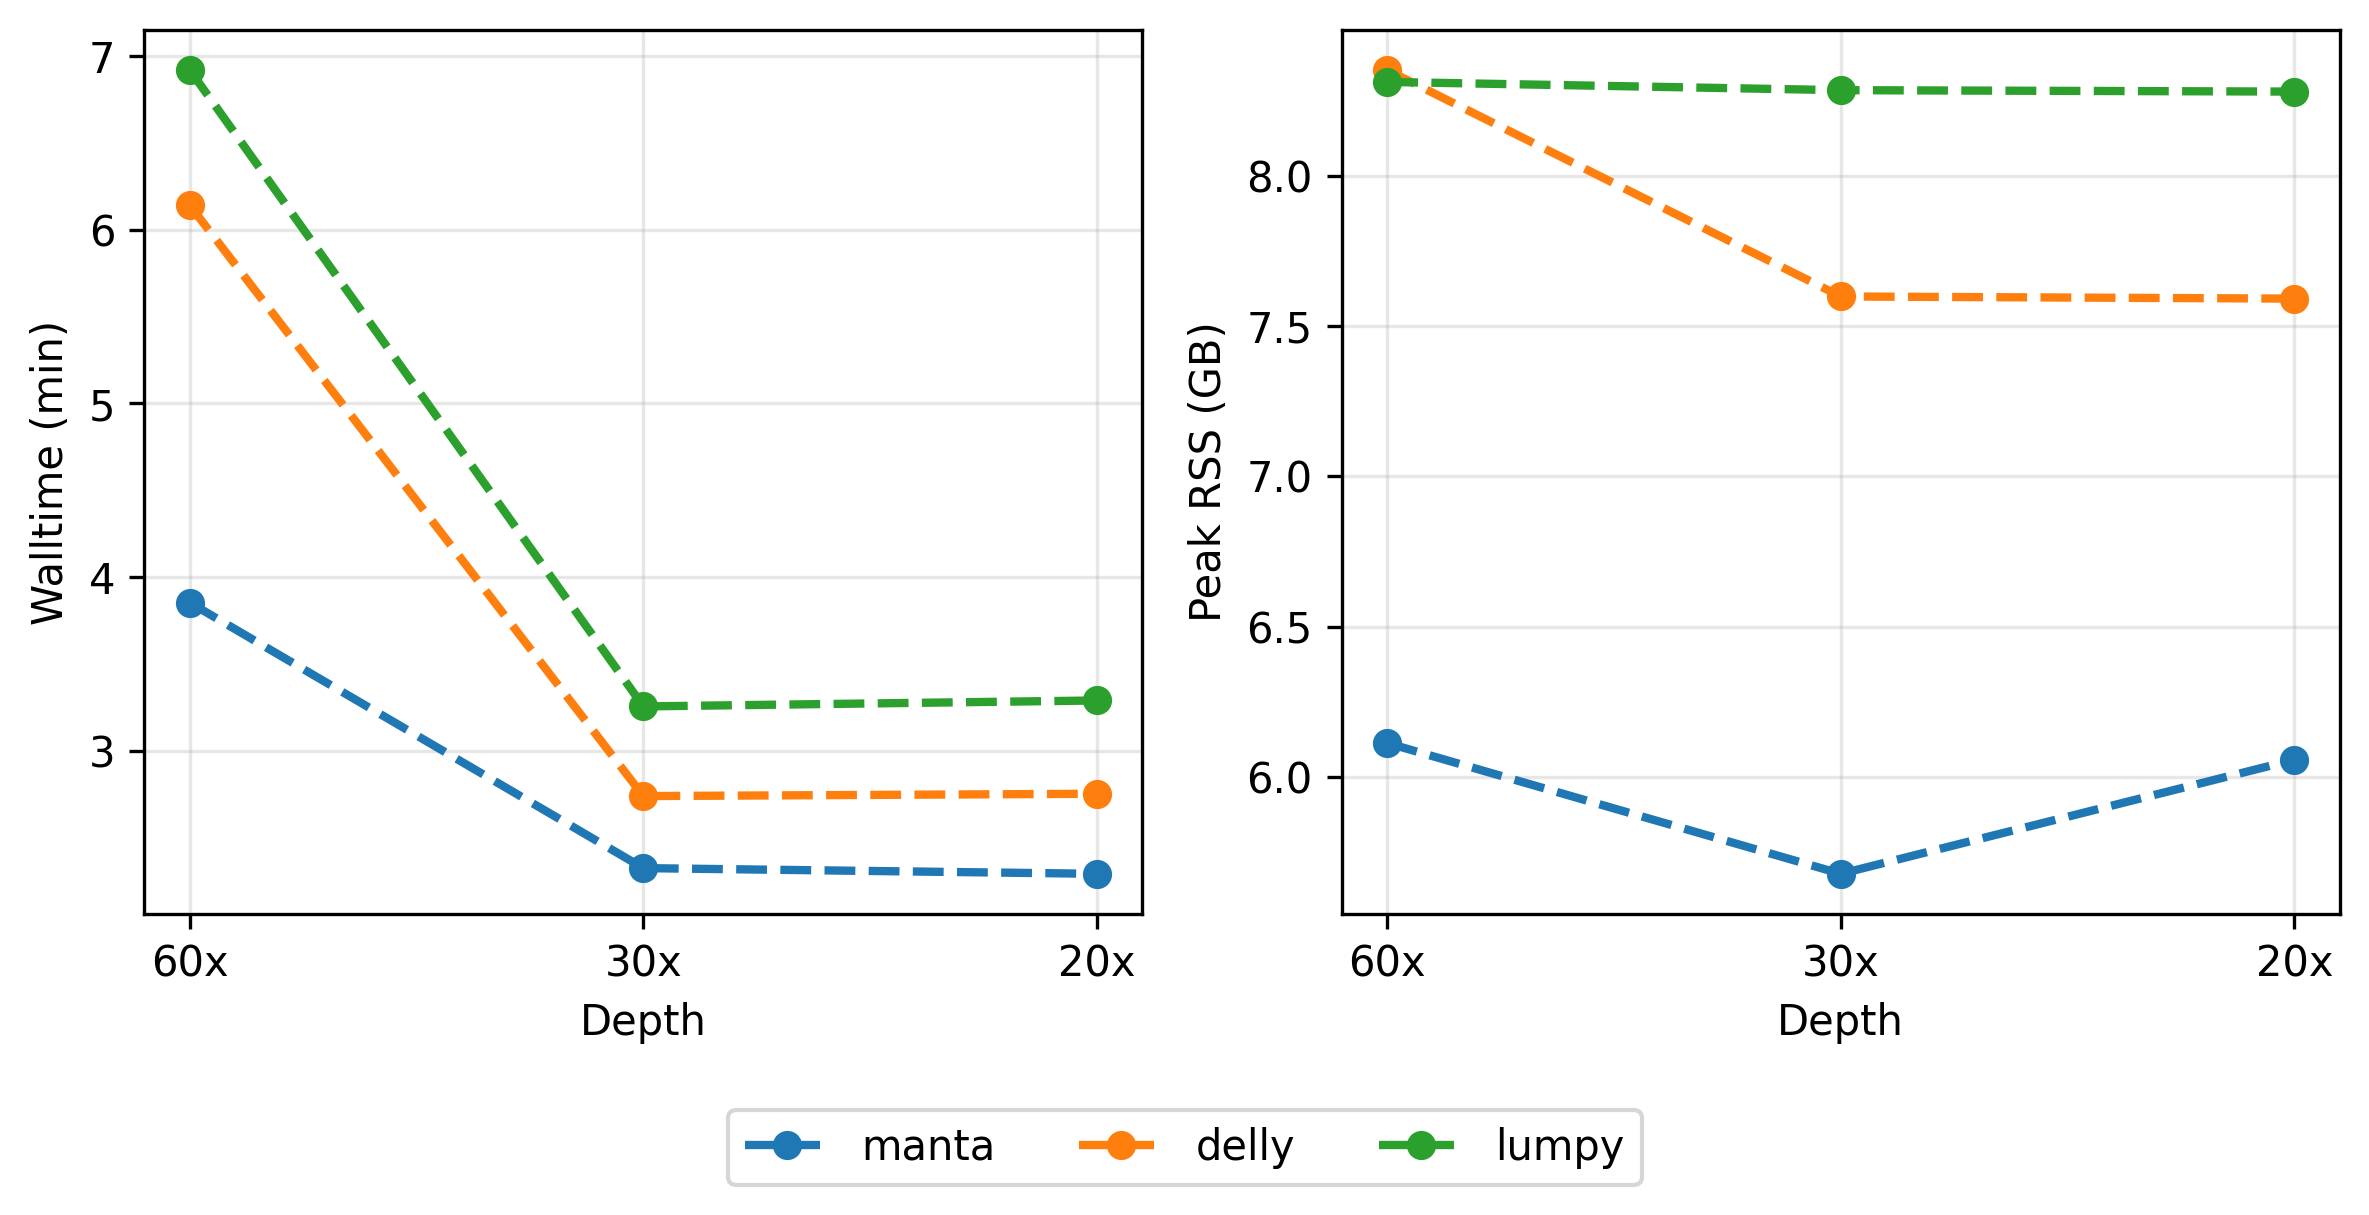

In [129]:
def plot_broken_line(data, ax, ylabel=None):
    depths = data.keys()
    val = {"manta": [], "delly": [], "lumpy": []}

    for depth in depths:
        for tool in val.keys():
            val[tool].append(data[depth]["either"].get(tool, None))
            
    for tool in val.keys():
        ax.plot(depths, val[tool], linestyle='--', marker='o', label=f'{tool}', linewidth=2, markersize=6)
    ax.set_xlabel('Depth')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
            
    return ax

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

plot_broken_line(time_dict, axes[0], ylabel='Walltime (min)')
plot_broken_line(memory_dict, axes[1], ylabel='Peak RSS (GB)')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
